In [4]:
import pandas as pd
import os
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt

# Load the font from a file
font_path = os.path.join(os.path.expanduser("~"), '.fonts/Palatino Linotype/palatinolinotype_roman.ttf')  # Replace with the actual path
custom_font = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path) 
print(custom_font.get_name())
plt.rcParams["font.family"] = "Palatino Linotype"

Palatino Linotype


In [5]:
STEERING_GOALS = ["reading_difficulty", "textual_diversity", "text_length", "formality"]

# Steerability metric calculation

In [6]:
CUT_POINTS = np.array([-1., -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 1.])

def bin_delta(delta, cutpoints):
    return np.digitize(delta, cutpoints[1:-1], right=False)

def get_dynamic_cutpoints(start_vector, cut_points=CUT_POINTS):
    # (N, d, 1) * (1, 1, C) => (N, d, C)
    return np.clip(start_vector[..., None] + cut_points[None, None, :], 0, 1)

def scalar_rejection(a, b): # b onto a
    #return np.sqrt(np.linalg.norm(b, axis=1) ** 2 - (np.sum(a * b, axis=1) / (np.linalg.norm(a, axis=1) + 1e-8)) ** 2)
    b_norm = np.sum(b * b, axis=1).values + 1e-8
    proj = (np.sum(a * b, axis=1) / b_norm).values.reshape(-1, 1) * b  # shape [n, d]
    rejection_vec = a - proj
    rejection = np.linalg.norm(rejection_vec, axis=1)
    return rejection

def scalar_projection(a, b):
    return np.sum(a * b, axis=1) / (np.linalg.norm(b, axis=1) + 1e-8)

def get_dist_to_goal(df, by_goal=False, steering_goals=STEERING_GOALS, cut_points=None):
    source = df[[f"source_{goal}" for goal in steering_goals]]
    output = df[[f"output_{goal}" for goal in steering_goals]]
    target = df[[f"target_{goal}" for goal in steering_goals]]
    target_corrected = target.where(pd.notnull(target), source.values)
    if cut_points is None:
        if by_goal:
            dists = pd.DataFrame(target_corrected.values - output.values, columns=steering_goals)
        else:
            dists = np.linalg.norm(output.values - target_corrected.values, axis=1)
    else:
        dynamic_cutpoints = get_dynamic_cutpoints(source.values)
        target_bins = np.sum(target_corrected.values[..., None] >= dynamic_cutpoints, axis=2) - 1
        obs_bins = np.sum(output.values[..., None] >= dynamic_cutpoints, axis=2) - 1
        if by_goal:
            dists = pd.DataFrame((obs_bins - target_bins) / (len(cut_points) - 1), columns=steering_goals)
        else:
            dists = np.linalg.norm((obs_bins - target_bins) / (len(cut_points) - 1), axis=1)
    return dists

def get_dist_from_source(df, by_goal=False, steering_goals=STEERING_GOALS, cut_points=None): # \hat{z} - z_0
    source = df[[f"source_{goal}" for goal in steering_goals]]
    output = df[[f"output_{goal}" for goal in steering_goals]]     
    if cut_points is None:      
        if by_goal:
            dists = pd.DataFrame(output.values - source.values, columns=steering_goals)
        else:
            dists = np.linalg.norm(output.values - source.values, axis=1)
    else:
        # number of bins actually moved
        assert len(cut_points) % 2 == 0 # if there is a "null" bin, bin # is odd, so cutpoint count is even
        bins_per_side = (len(cut_points) - 2) / 2
        dynamic_cutpoints = get_dynamic_cutpoints(source.values)
        output_bins = np.sum(output.values[..., None] >= dynamic_cutpoints, axis=2) - 1 - bins_per_side # in the 7-bin direct prompt, bin 3 is always the original source text
        if by_goal:
            dists = pd.DataFrame(output_bins / (len(cut_points) - 1), columns=steering_goals)
        else:
            dists = np.linalg.norm(output_bins / (len(cut_points) - 1), axis=1)
    return dists


def get_dist_requested(df, by_goal=False, steering_goals=STEERING_GOALS, cut_points=None): # z^* - z_0
    source = df[[f"source_{goal}" for goal in steering_goals]]
    target = df[[f"target_{goal}" for goal in steering_goals]]  
        
    target_corrected = target.where(pd.notnull(target), source.values)
    if cut_points is None:
        if by_goal:
            dists = pd.DataFrame(target_corrected.values - source.values, columns=steering_goals)
        else:
            dists = np.linalg.norm(source.values - target_corrected.values, axis=1)
    else:
        # number of bins of movement requested 
        assert len(cut_points) % 2 == 0
        bins_per_side = (len(cut_points) - 2) / 2
        delta = df[[f"delta_{goal}" for goal in steering_goals]]
        delta_corrected = delta.fillna(0.).values
        delta_bins = np.sum(delta_corrected[..., None] >= cut_points, axis=2) - 1 - bins_per_side
        if by_goal:
            dists = pd.DataFrame(delta_bins / (len(cut_points) - 1), columns=steering_goals)
        else:
            dists = np.linalg.norm(delta_bins / (len(cut_points) - 1), axis=1)
    return dists

def get_orthogonality(df, steering_goals=STEERING_GOALS, normalize=True, cut_points=None):
    dist_to_goal = get_dist_to_goal(df, by_goal=True, steering_goals=steering_goals, cut_points=cut_points)
    dist_from_goal_actual = get_dist_from_source(df, by_goal=True, steering_goals=steering_goals, cut_points=cut_points)
    dist_requested = get_dist_requested(df, by_goal=True, steering_goals=steering_goals)

    dist_from_goal_norm = np.linalg.norm(dist_from_goal_actual, axis=1) 
    dist_requested_norm = np.linalg.norm(dist_requested, axis=1)

    denom = dist_from_goal_norm + 1e-4 * (dist_requested_norm + 1e-8)
    rej = scalar_rejection(dist_to_goal, dist_requested)
    if normalize:
        ortho = np.clip(rej / denom, 0, 1) 
    else:
        ortho = rej
    return ortho


def get_miscalibration(df, steering_goals=STEERING_GOALS, normalize=True, cut_points=None):
    dist_to_goal = get_dist_to_goal(df, by_goal=True, steering_goals=steering_goals, cut_points=cut_points)
    dist_from_goal_ideal = get_dist_requested(df, by_goal=True, steering_goals=steering_goals, cut_points=cut_points)
    denom = np.linalg.norm(dist_from_goal_ideal, axis=1) + 1e-8
    abs_proj_dist = np.abs(scalar_projection(dist_to_goal, dist_from_goal_ideal))
    if normalize:
        miscal = abs_proj_dist / denom
    else:
        miscal = abs_proj_dist 
    return miscal

# Plotting helpers

In [11]:
def preview_samples(df, n=10, topk=None, ranking_function=get_dist_to_goal, steering_goals=STEERING_GOALS):
    def wrap_and_truncate(text):
        if not isinstance(text, str):
            return text
        wrapped = '\n'.join([text[i:i+100] for i in range(0, len(text), 100)])
        return wrapped[:5000] + ('...' if len(text) > 5000 else '')

    with pd.option_context('display.max_colwidth', None):  # Allow full colwidth before manual wrapping
        subset = df.filter(regex="^(text$|instruction$|llm_response|source_(?!text_is_a)|output_(?!raw))", axis=1)
        if topk is None:
            sample = subset.sample(n=n, random_state=42)
            for col in ['text', 'instruction', 'llm_response']:
                if col in sample.columns:
                    sample[col] = sample[col].apply(wrap_and_truncate)
        else:
            print(f"`topk` is not None ({topk}) -- ignoring n.")
            indices = np.argsort(ranking_function(df, steering_goals=steering_goals))
            if topk > 0:
                sample = subset.iloc[indices[:topk]] # best
            else: # negative 
                sample = subset.iloc[indices[topk:]] # worst
        display(sample) 

def fix_violin(violin, color):
    for pc in violin['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
        pc.set_zorder(2)

    violin['cbars'].set_color(color) 
    violin['cbars'].set_zorder(1)

    violin['cmedians'].set_color('black')
    violin['cmedians'].set_linewidth(1.)
    violin['cmedians'].set_zorder(2)

    violin['cmins'].set_color('black')  # Minimum horizontal line
    violin['cmins'].set_linewidth(1.)
    violin['cmaxes'].set_color('black')  # Maximum horizontal line
    violin['cmaxes'].set_linewidth(1.)
    violin['cmins'].set_zorder(1)
    violin['cmaxes'].set_zorder(1)

def get_outlier_mask(series):
    lo, hi = np.percentile(series, [2.5, 97.5])
    outlier_mask = (series > hi) | (series < lo)
    return outlier_mask

def create_violin_subplot(data, position, color, ax, text_height, scatter_sz=25, text_offset=0.2, fontsize=8):

    def fmt_val(val):
        return f"{val:.3f}".lstrip("0")

    outlier_mask = get_outlier_mask(data)
    truncated_data = data[~outlier_mask]
    violin = ax.violinplot(
        truncated_data,
        positions=[position], 
        widths=0.6,
        bw_method=0.15,
        showmedians=True,
    )
    ax.scatter([position] * outlier_mask.sum(), data[outlier_mask], alpha=0.2,
                color=color, marker=".", s=scatter_sz, linewidths=0.5, edgecolor="gray")
    fix_violin(violin, color)
    mean_val = np.median(data)
    #std_val = np.std(data)
    iqr_val = np.percentile(data, 75) - np.percentile(data, 25)
    ax.text(
        position, text_height, #np.quantile(data, 0.999) * 1.0, 
        f"{fmt_val(mean_val)}\n({fmt_val(iqr_val)})",
        ha="center", va="bottom", fontsize=fontsize, fontweight="bold"
    )

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(*rgb)

def interpolate_colors(start_hex, end_hex, n):
    start_rgb = hex_to_rgb(start_hex)
    end_rgb = hex_to_rgb(end_hex)
    
    interpolated = []
    for i in range(n):
        ratio = i / (n - 1) if n > 1 else 0
        rgb = tuple(
            int(start_rgb[j] + (end_rgb[j] - start_rgb[j]) * ratio)
            for j in range(3)
        )
        interpolated.append(rgb_to_hex(rgb))
    
    return interpolated

def get_grounded_subset(df, flip=False):
    mask = (df["rationale_approved"] & (df["answer"] == "Yes")) | (~df["rationale_approved"] & (df["answer"] == "No"))
    print(f"{mask.sum()}/{len(df)} rewrites passed groudnedness check | {(df['answer'] == 'No').sum()} flagged | {(~df['rationale_approved']).sum()} overruled")
    if flip:
        mask = ~mask
    return df.loc[mask]

def compute_bar_positions(total_bars, group_sizes, spacing=0.3):
    positions = []

    # Handle integer: divide evenly
    if isinstance(group_sizes, int):
        per_group = total_bars // group_sizes
        group_sizes_list = [per_group] * group_sizes
        remainder = total_bars % group_sizes
        for i in range(remainder):
            group_sizes_list[i] += 1
    else:
        group_sizes_list = group_sizes

    current_base = 0
    for size in group_sizes_list:
        positions.extend([current_base + i for i in range(size)])
        current_base += size + spacing

    return positions


def plot_steerability_metrics(results, colors, names,
                        legend_y, group_sizes=1, control=None,
                          legend_title="Model", save=None,
                          steering_goals=STEERING_GOALS,
                          exclude_degenerate=True, wide=True,
                          steer_height=0.7, miscal_height=2., ortho_height=1.2, 
                          figsize=(8, 2), suptitle=None,
                          suptitle_y=0.9, normalize=True,
                          cut_points=None, ncols=None):
    handles = []
    positions = compute_bar_positions(len(results), group_sizes)

    if wide:
        fig, axs = plt.subplots(1, 3, figsize=figsize)
    else:
        fig, axs = plt.subplots(3, 1, figsize=figsize)

    sup = None
    if suptitle is not None:
        sup = fig.suptitle(suptitle, y=suptitle_y)

    axs[0].set_ylabel(r"$\vert\vert \mathbf{\hat{z}} - \mathbf{z}^* \vert\vert_2$")
    axs[1].set_ylabel(r"Miscalibration")
    axs[2].set_ylabel(r"Orthogonality")

    axs[0].set_xlabel("")
    axs[1].set_xlabel("")
    axs[2].set_xlabel("")

    if control is not None:
        control_dist = get_dist_to_goal(control, steering_goals=steering_goals, cut_points=cut_points)
        control_miscal = get_miscalibration(control, steering_goals=steering_goals, normalize=normalize, cut_points=cut_points)
        control_ortho = get_orthogonality(control, steering_goals=steering_goals, normalize=normalize, cut_points=cut_points)

    for i, (df, color) in enumerate(zip(results, colors)):
        if exclude_degenerate:
            df = get_grounded_subset(df)
        dist = get_dist_to_goal(df, steering_goals=steering_goals, cut_points=cut_points)
        if control is not None:
            dist = dist - control_dist
            print("% improved, steerability:", (dist < 0).mean())
        create_violin_subplot(dist, positions[i], color, axs[0], steer_height)

        miscal = get_miscalibration(df, steering_goals=steering_goals, normalize=normalize, cut_points=cut_points)
        if control is not None:
            miscal = miscal - control_miscal
            print("% improved, miscal:", (miscal < 0).mean())
        create_violin_subplot(miscal, positions[i], color, axs[1], miscal_height)

        ortho = get_orthogonality(df, steering_goals=steering_goals, normalize=normalize, cut_points=cut_points)
        if control is not None:
            ortho = ortho - control_ortho
            print("% improved, ortho:", (ortho < 0).mean())

        create_violin_subplot(ortho, positions[i], color, axs[2], ortho_height)

        # for legend
        patch = mpatches.Patch(color=color)
        handles.append(patch)

    for ax in axs:
        ax.tick_params(axis="x", length=0)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xlim((min(positions) - 1, max(positions) + 1))
        ax.set_xticklabels([])


    if control is not None:
        axs[0].set_ylim((-0.7, 0.5))
        axs[1].set_ylim((-2, 3.))
        axs[2].set_ylim((-1, 1.02))
        axs[0].hlines([-1.0, -0.5, 0, 0.5, 1.0, 1.5], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[1].hlines([-2., 0., 2., 4.], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[2].hlines([-1., -0.5, 0, 0.5, 1], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
    else:
        axs[0].set_ylim((-0.05, 1.5))
        axs[1].set_ylim((-0.05, 3.))
        axs[2].set_ylim((-0.05, 1.02))
        axs[0].hlines([0, 0.4, 0.8, 1.2], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[1].hlines([0, 1, 2, 3], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[2].hlines([0, 0.25, 0.5, 0.75, 1], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)

    #fig.suptitle(suptitle)
    lgd = fig.legend(
        handles,
        names, # + ["Perfect steerability"],
        ncols=min(len(results) + 1, 7 if wide else 4) if ncols is None else ncols,
        loc="lower center",
        bbox_to_anchor=(0.5, legend_y),
        title=legend_title,
    )
    fig.tight_layout()
    if save is not None:
        fig.savefig(f"figures/{save}.pdf", bbox_inches="tight", bbox_extra_artists=(lgd, sup))
    fig.show()
    return dist, miscal, ortho



2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 5 overruled
2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 2 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 2 flagged | 2 overruled
2047/2048 rewrites passed groudnedness check | 5 flagged | 4 overruled
2048/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled


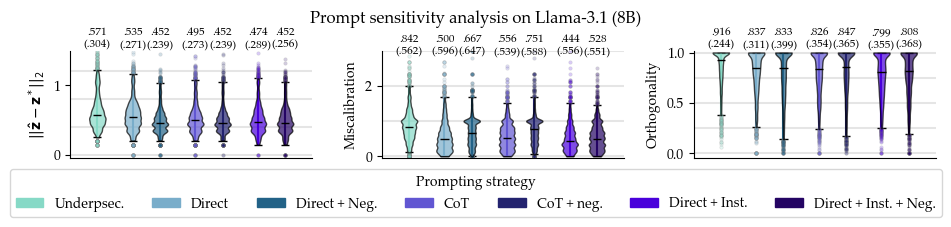

In [14]:
llama_results = [
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_underspec_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),

    #pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_one_to_ten_judged.csv", index_col=0),
    #pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_one_to_ten_neg_judged.csv", index_col=0),

    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_cot_v3_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_cot_v3_neg_judged.csv", index_col=0),

    #pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_inst_only_judged.csv", index_col=0),

    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_dir_inst_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_dir_inst_neg_judged.csv", index_col=0),
]




llama3_1_colors = interpolate_colors("#86d9c6", "#4900db",  6)
llama3_1_neg_colors = interpolate_colors("#226287", "#240463", 4)
final_colors = [
    llama3_1_colors[0],
    llama3_1_colors[1], llama3_1_neg_colors[0],
    #llama3_1_colors[2], llama3_1_neg_colors[1],
    llama3_1_colors[3], llama3_1_neg_colors[2],
    #llama3_1_colors[4],
    llama3_1_colors[5], llama3_1_neg_colors[3]
]

llama3_1_names = ["Underpsec.", "Direct", "Direct + Neg.",
                  #"1-10 scale", "1-10 scale + Neg.",
                  "CoT", "CoT + neg.", "Direct + Inst.", "Direct + Inst. + Neg."]

_ = plot_steerability_metrics(
    llama_results,
    final_colors,
    llama3_1_names,
    -0.22,
    group_sizes=[1, 2, 2, 2],
    suptitle="Prompt sensitivity analysis on Llama-3.1 (8B)",
    suptitle_y=0.85,
    figsize=(9.5, 2.),
    legend_title="Prompting strategy",
    save="llama3.1_prompts_v2_disc",
    steer_height=1.5, miscal_height=2.8, ortho_height=1.02,
    cut_points=CUT_POINTS
)

In [15]:
llama_results = [
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_underspec_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),

    #pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_one_to_ten_judged.csv", index_col=0),
    #pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_one_to_ten_neg_judged.csv", index_col=0),

    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_cot_v3_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_cot_v3_neg_judged.csv", index_col=0),

    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_inst_only_judged.csv", index_col=0),

    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_dir_inst_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_dir_inst_neg_judged.csv", index_col=0),
]




llama3_1_colors = interpolate_colors("#86d9c6", "#4900db",  5)
llama3_1_neg_colors = interpolate_colors("#226287", "#240463", 3)
final_colors = [
    llama3_1_colors[0],
    llama3_1_colors[1], llama3_1_neg_colors[0],
    #llama3_1_colors[2], llama3_1_neg_colors[1],
    llama3_1_colors[2], llama3_1_neg_colors[1],
    llama3_1_colors[3],
    llama3_1_colors[4], llama3_1_neg_colors[2]
]

llama3_1_names = ["Underspec.", "Direct", "Direct + Neg.",
                 # "1-10 scale", "1-10 scale + Neg.",
                  "CoT", "CoT + neg.", "Inst.",  "Direct + Inst.", "Direct + Inst. + Neg."]



2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 5 overruled
2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 2 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 2 flagged | 2 overruled
2044/2048 rewrites passed groudnedness check | 5 flagged | 1 overruled
2047/2048 rewrites passed groudnedness check | 5 flagged | 4 overruled
2048/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled


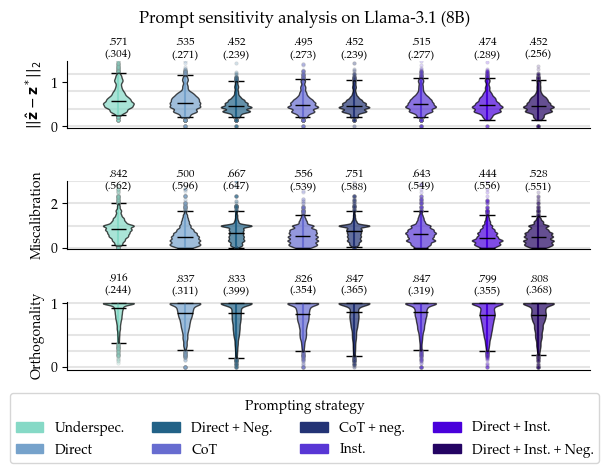

In [16]:
_ = plot_steerability_metrics(
    llama_results,
    final_colors,
    llama3_1_names,
    -0.2,
    group_sizes=[1, 2, 2, 1, 2],
    suptitle="Prompt sensitivity analysis on Llama-3.1 (8B)",
    suptitle_y=0.95,
    figsize=(6, 4.),
    wide=False,
    legend_title="Prompting strategy",
    save="llama3.1_prompts_all",
    steer_height=1.5, miscal_height=2.5, ortho_height=1.1,
    cut_points=CUT_POINTS,
)

In [17]:
def harmonic_mean(x, y):
    return 2 * (x * y) / (x + y)

print([
    harmonic_mean(0.81, 0.84),
    harmonic_mean(0.56, 0.77),
    harmonic_mean(0.58, 0.76),
    harmonic_mean(0.57, 0.76),
    harmonic_mean(0.63, 0.79),
    harmonic_mean(0.53, 0.74),
])


[0.8247272727272728, 0.648421052631579, 0.657910447761194, 0.6514285714285714, 0.7009859154929579, 0.6176377952755905]


2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2044/2048 rewrites passed groudnedness check | 15 flagged | 11 overruled
2048/2048 rewrites passed groudnedness check | 2 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled


(array([0.54779848, 0.84280911, 1.00357668, ..., 0.80295081, 0.4203212 ,
        0.75549895]),
 0       0.429347
 1       1.126950
 2       0.764079
 3       0.571098
 4       0.287727
           ...   
 2043    0.086306
 2044    0.717173
 2045    0.794551
 2046    0.155951
 2047    0.999235
 Length: 2048, dtype: float64,
 array([0.72151196, 0.69301582, 0.98099189, ..., 0.96780572, 0.52517519,
        0.99961576]))

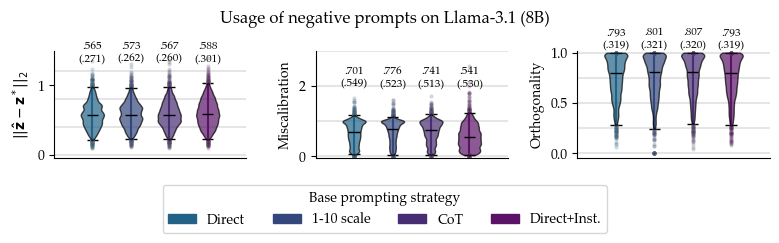

In [22]:
llama_negprompts = [
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_one_to_ten_neg_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_cot_v3_neg_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_dir_inst_neg_judged.csv", index_col=0),
]

llama3_1_colors = interpolate_colors("#226287", "#5a1366", len(llama_negprompts))
llama3_1_names = ["Direct", "1-10 scale", "CoT", "Direct+Inst."]

plot_steerability_metrics(
    llama_negprompts,
    llama3_1_colors,
    llama3_1_names,
    -0.3,
    group_sizes=1,
    suptitle="Usage of negative prompts on Llama-3.1 (8B)",
    suptitle_y=0.85,
    legend_title="Base prompting strategy",
    save="llama3.1_negprompts",
    ortho_height=1.02, steer_height=1.3, miscal_height=1.9,
)

2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2047/2048 rewrites passed groudnedness check | 2 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 3 flagged | 3 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 5 overruled
2048/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled


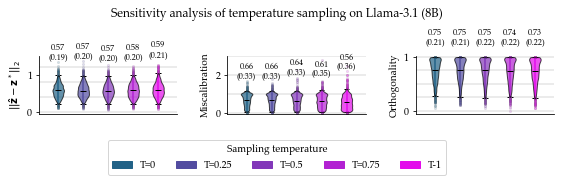

In [41]:
llama_temp = [
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_t0.25_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_t0.5_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_t0.75_judged.csv", index_col=0),
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_t1_judged.csv", index_col=0),
]

llama3_1_colors = interpolate_colors("#226287", "#e30ceb", len(llama_temp))
llama3_1_names = ["T=0", "T=0.25", "T=0.5", "T=0.75", "T-1"]

plot_steerability_metrics(
    llama_temp,
    llama3_1_colors,
    llama3_1_names,
    -0.35,
    group_sizes=len(llama_temp),
    suptitle="Sensitivity analysis of temperature sampling on Llama-3.1 (8B)",
    suptitle_y=0.85,
    legend_title="Sampling temperature",
    save="llama3.1_temp"
)

In [24]:
def extract_oracle_best(df, mode="best", steering_goals=STEERING_GOALS):
    target_goals = [f"target_{goal}" for goal in steering_goals]
    if mode == "best":
        best_completions = df.groupby(["text"] + target_goals) \
            .apply(lambda group: group.iloc[get_dist_to_goal(group, steering_goals=steering_goals).argmin()]) \
            .reset_index(drop=True)
    elif mode == "worst":
        best_completions = df.groupby(["text"] + target_goals) \
            .apply(lambda group: group.iloc[get_dist_to_goal(group, steering_goals=steering_goals).argmax()]) \
            .reset_index(drop=True)
    elif mode == "median":
        def argmedian(group):
            target_dist = get_dist_to_goal(group, steering_goals=steering_goals)
            med = target_dist.median()
            med_dist = np.abs(target_dist - med)
            return med_dist.argmin()
        
        best_completions = df.groupby(["text"] + target_goals) \
            .apply(lambda group: argmedian(group)) \
            .reset_index(drop=True)
    else:
        raise ValueError()
    return best_completions

def post_process_oracle(df, steering_goals=STEERING_GOALS):
    source = df[[f"source_{goal}" for goal in steering_goals]]
    target = df[[f"target_{goal}" for goal in steering_goals]] 
    delta = df[[f"delta_{goal}" for goal in steering_goals]]  
 
    df.loc[:, [f"target_{goal}" for goal in steering_goals]] = np.where(target == -1., source.values, target)
    df.loc[:, [f"delta_{goal}" for goal in steering_goals]] = np.where(delta == -1., 0., delta)
    return df


2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 1 flagged | 1 overruled
2047/2048 rewrites passed groudnedness check | 9 flagged | 8 overruled
2048/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled
2048/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled
2046/2048 rewrites passed groudnedness check | 3 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 1 flagged | 1 overruled


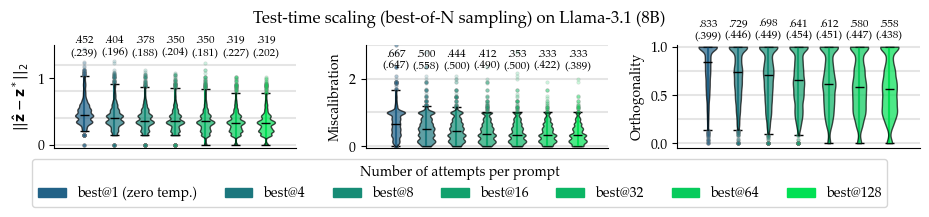

In [26]:

llama_oracle = [
    pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b4_judged.csv", index_col=0)),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b8_judged.csv", index_col=0)),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b16_judged.csv", index_col=0)),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b32_judged.csv", index_col=0)),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b64_judged.csv", index_col=0)),
    post_process_oracle(pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_b128_judged.csv", index_col=0)),

]

llama3_1_colors = interpolate_colors("#226287", "#02e054", len(llama_oracle))
llama3_1_names = ["best@1 (zero temp.)", 
                  "best@4",
                  "best@8", "best@16", "best@32", "best@64", "best@128"]

_ = plot_steerability_metrics(
    llama_oracle,
    llama3_1_colors,
    llama3_1_names,
    -0.22,
    group_sizes=1,
    suptitle="Test-time scaling (best-of-N sampling) on Llama-3.1 (8B)",
    suptitle_y=0.8,
    legend_title="Number of attempts per prompt",
    save="llama3.1_oracle_disc",
    figsize=(9.5, 2),
    cut_points=CUT_POINTS,
    steer_height=1.3,
    miscal_height=2.2,
    ortho_height=1.05,
)


2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 7 overruled
2047/2048 rewrites passed groudnedness check | 19 flagged | 18 overruled
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 5 overruled
2046/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled


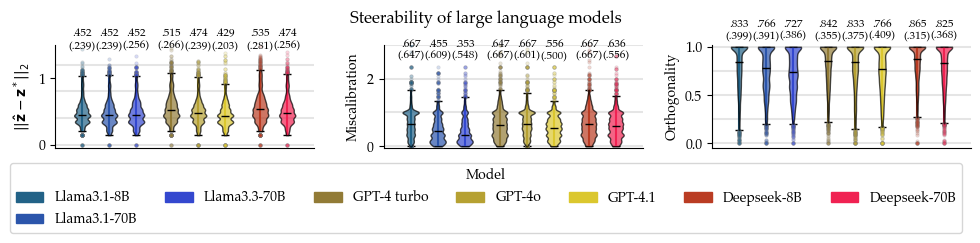

In [28]:
models = [
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_70b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.3_70b_judged.csv", index_col=0),

    #pd.read_csv("./judge_results/grounding/v2.1_gpt35_turbo_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_gpt4_turbo_2024_04_09_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_gpt4o_2024_08_06_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_gpt4.1_2025_04_14_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_deepseek_8b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_deepseek_70b_judged.csv", index_col=0),

    #pd.read_csv("./judge_results/grounding/v2.1_o1_mini_2024_09_12_judged.csv", index_col=0),
    #pd.read_csv("./judge_results/grounding/v2.1_o3_mini_2025_01_31_judged.csv", index_col=0),
]


model_colors = interpolate_colors("#226287", "#3448cf", 3) + interpolate_colors("#6e563b", "#dbc72e", 4)[1:] + interpolate_colors("#ba3c23", "#f02252", 2)
model_names = ["Llama3.1-8B", "Llama3.1-70B",
               "Llama3.3-70B",
               #"GPT-3.5 turbo",
               "GPT-4 turbo",
               "GPT-4o", "GPT-4.1", "Deepseek-8B", "Deepseek-70B"]

_ = plot_steerability_metrics(
    models,
    model_colors,
    model_names,
    -0.35,
    group_sizes=[3, 3, 2],
    suptitle="Steerability of large language models",
    suptitle_y=0.8,
    legend_title="Model",
    figsize=(10., 2),
    save="steerability_v4_disc",
    cut_points=CUT_POINTS,
     steer_height=1.4,
    miscal_height=2.5,
    ortho_height=1.05,
)


In [29]:
main_models = [
    pd.read_csv("./judge_results/grounding/v2.1_llama3_8b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3_70b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_70b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.3_70b_judged.csv", index_col=0),

    pd.read_csv("./judge_results/grounding/v2.1_gpt35_turbo_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_gpt4_turbo_2024_04_09_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_gpt4o_2024_08_06_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_gpt4.1_2025_04_14_judged.csv", index_col=0),

    pd.read_csv("./judge_results/grounding/v2.1_o1_mini_2024_09_12_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_o3_mini_2025_01_31_judged.csv", index_col=0),

    pd.read_csv("./judge_results/grounding/v2.1_deepseek_8b_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/v2.1_deepseek_70b_judged.csv", index_col=0),


    pd.read_csv("./judge_results/grounding/qwen_moe_zerobrain_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/qwen_moe_bigbrain_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/qwen_32b_zerobrain_judged.csv", index_col=0),
    pd.read_csv("./judge_results/grounding/qwen_32b_bigbrain_judged.csv", index_col=0),
]


model_colors = interpolate_colors("#68adbd", "#3448cf", 5) + interpolate_colors("#6e563b", "#dbc72e", 4) + interpolate_colors("#8c5303", "#c76c38", 2) \
    + interpolate_colors("#ba3c23", "#f02252", 2) + interpolate_colors("#d3c9d6", "#554f57", 4)
model_names = ["Llama3-8B", "Llama3-70B",
    "Llama3.1-8B", "Llama3.1-70B",
               "Llama3.3-70B",
               "GPT-3.5 turbo",
               "GPT-4 turbo",
               "GPT-4o", "GPT-4.1", 
               "o1-mini", "o3-mini",
               "Deepseek-8B", "Deepseek-70B",
               "Qwen3-30B-A3B", "Qwen3-30B-A3B-Thinking",
               "Qwen3-32B", "Qwen3-32B-Thinking"]




2048/2048 rewrites passed groudnedness check | 8 flagged | 8 overruled
2048/2048 rewrites passed groudnedness check | 8 flagged | 8 overruled
2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 7 overruled
2047/2048 rewrites passed groudnedness check | 19 flagged | 18 overruled
2045/2048 rewrites passed groudnedness check | 41 flagged | 40 overruled
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled
2026/2048 rewrites passed groudnedness check | 23 flagged | 1 overruled
2024/2048 rewrites passed groudnedness check | 23 flagged | 4 overruled
2047/2048 rewrites passed groudnedness check | 6 flagged | 5 overruled
2046/2048 rewrites passed groudnedness check | 4 flagged | 4 overruled
2047/2048 rewrites passed groudnedness check | 5 flagged | 4 overruled


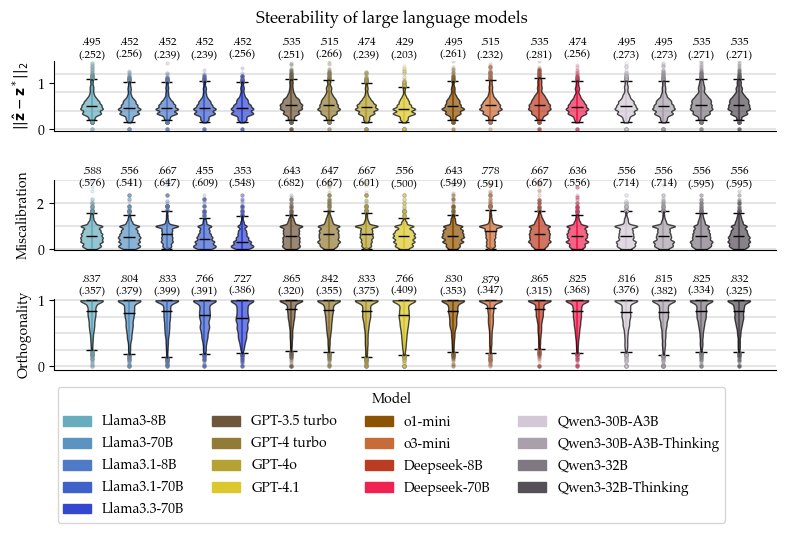

In [30]:
_ = plot_steerability_metrics(
    main_models,
    model_colors,
    model_names,
    -0.35,
    group_sizes=[5, 4, 2, 2, 4],
    suptitle="Steerability of large language models",
    suptitle_y=0.95,
    legend_title="Model",
    figsize=(8., 4),
    wide=False,
    save="steerability_every_model",
    cut_points=CUT_POINTS,
    steer_height=1.5, miscal_height=2.6, ortho_height=1.05,
)

2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2047/2048 rewrites passed groudnedness check | 3 flagged | 4 overruled
2042/2048 rewrites passed groudnedness check | 6 flagged | 2 overruled
2048/2048 rewrites passed groudnedness check | 0 flagged | 0 overruled


(array([0.79102526, 0.83786683, 0.77543585, ..., 0.77562326, 0.42026186,
        0.41765337]),
 0       0.899574
 1       1.081817
 2       0.325530
 3       0.618823
 4       0.214560
           ...   
 2043    0.248692
 2044    0.197476
 2045    0.217932
 2046    0.270770
 2047    0.307260
 Length: 2048, dtype: float64,
 array([0.94662566, 0.91592282, 0.72673691, ..., 0.78790669, 0.50973417,
        0.53955806]))

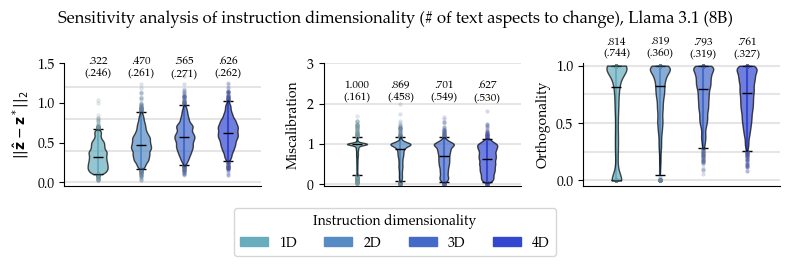

In [36]:
dimensions = [
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_8b_1d_judged.csv"),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_8b_2d_judged.csv"),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_8b_negprompt_judged.csv"),
    pd.read_csv("./judge_results/grounding/v2.1_llama3.1_8b_4d_judged.csv")
]

names = ["1D", "2D", "3D", "4D"]

plot_steerability_metrics(
    dimensions,
    interpolate_colors("#68adbd", "#3448cf", 4),
    names,
    -0.25,
    group_sizes=len(names),
    suptitle="Sensitivity analysis of instruction dimensionality (# of text aspects to change), Llama 3.1 (8B)",
    suptitle_y=0.9,
    legend_title="Instruction dimensionality",
    figsize=(8., 2.2),
    save="steerability_dimensions",
    steer_height=1.3, miscal_height=2.0, ortho_height=1.05,
)

## Trained models

135
28
0
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled


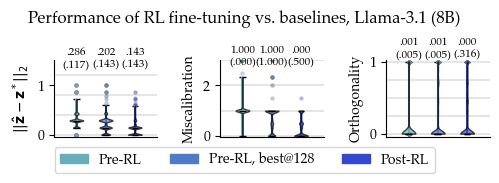

In [41]:
from functools import reduce

staged = [
    pd.read_csv("./judge_results/grounding/tuning_stage_0_judged.csv"),
    #pd.read_csv("./judge_results/grounding/tuning_stage_2a_pareto_judged.csv"),
    #post_process_oracle(pd.read_csv("./judge_results/grounding/tuning_stage_0_b4_judged.csv"), steering_goals=["reading_difficulty", "formality"]),
    #post_process_oracle(pd.read_csv("./judge_results/grounding/tuning_stage_0_b8_judged.csv"), steering_goals=["reading_difficulty", "formality"]),
    #post_process_oracle(pd.read_csv("./judge_results/grounding/tuning_stage_0_b16_judged.csv"), steering_goals=["reading_difficulty", "formality"]),
    #post_process_oracle(pd.read_csv("./judge_results/grounding/tuning_stage_0_b32_judged.csv"), steering_goals=["reading_difficulty", "formality"]),
    post_process_oracle(pd.read_csv("./judge_results/grounding/meta_test_b128_judged.csv"), steering_goals=["reading_difficulty", "formality"]),
    pd.read_csv("./judge_results/grounding/vanilla_rl_judged.csv"),

]

for df in staged:
     print((df["text"] == df["llm_response"]).sum())
trivial_repeat = reduce(np.logical_or, [(df["text"] == df["llm_response"]) for df in staged])
staged_filtered = [df.loc[~trivial_repeat] for df in staged]


names = ["Pre-RL", 
         #"Stage 2A (Pareto)",
        # "best@16",
        # "best@32",
         "Pre-RL, best@128", "Post-RL", ]

_ = plot_steerability_metrics(
    staged,
    interpolate_colors("#68adbd", "#3448cf", len(names)),
    names,
    -0.12,
    group_sizes=len(names),
    suptitle="Performance of RL fine-tuning vs. baselines, Llama-3.1 (8B)",
    #suptitle="Compari, Llama 3.1 (8B)",
    suptitle_y=0.88,
    legend_title="",
    figsize=(5.2, 1.7),
    save="steer_tuning_unfiltered",
    steering_goals=["reading_difficulty", "formality"],
    #control=staged[0],
    normalize=True,
    cut_points=CUT_POINTS,
    steer_height=1.3, miscal_height=2.7, ortho_height=1.02
)

627/627 rewrites passed groudnedness check | 0 flagged | 0 overruled
626/627 rewrites passed groudnedness check | 0 flagged | 1 overruled
627/627 rewrites passed groudnedness check | 0 flagged | 0 overruled
397/397 rewrites passed groudnedness check | 0 flagged | 0 overruled
397/397 rewrites passed groudnedness check | 0 flagged | 0 overruled
397/397 rewrites passed groudnedness check | 0 flagged | 0 overruled


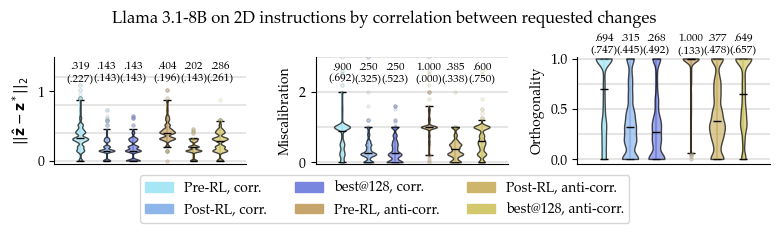

In [43]:
from itertools import chain

results_2d = [
    pd.read_csv("./judge_results/grounding/stage_0_2d_judged.csv"),
    pd.read_csv("./judge_results/grounding/vanilla_rl_2d_judged.csv"),
    post_process_oracle(pd.read_csv("./judge_results/grounding/meta_test_b128_2d_judged.csv"), steering_goals=["reading_difficulty", "formality"]),
]

def decompose_entangled(*dfs, goal1="formality", goal2="reading_difficulty"):
    results = []
    for df in dfs:
        results.append([
            df.loc[df[f"delta_{goal1}"] * df[f"delta_{goal2}"] > 0], df.loc[df[f"delta_{goal1}"] * df[f"delta_{goal2}"] < 0], 
        ])
    return list(chain.from_iterable(zip(*results)))

inst_by_corr = decompose_entangled(*results_2d)

names = [
    "Pre-RL, corr.", "Post-RL, corr.", "best@128, corr.",
    "Pre-RL, anti-corr.", "Post-RL, anti-corr.", "best@128, anti-corr."
    ]

vanilla_colors = interpolate_colors("#68adbd", "#3448cf", 2)
corr_colors = interpolate_colors("#a6e6f5", "#7986e0", 3)
anticorr_colors = interpolate_colors("#c7a46b", "#d4c86e", 3)


_ = plot_steerability_metrics(
    inst_by_corr,
    corr_colors + anticorr_colors,
    names,
    -0.22,
    group_sizes=[3, 3],
    suptitle="Llama 3.1-8B on 2D instructions by correlation between requested changes",
    suptitle_y=0.88,
    legend_title="",
    figsize=(8., 2.),
    save="steer_tuning_entangling",
    steering_goals=["reading_difficulty", "formality"],
    #control=staged[0],
    normalize=True,
    ncols=3,
    cut_points=CUT_POINTS,
    steer_height=1.1, miscal_height=2.2, ortho_height=1.02,
)


615/615 rewrites passed groudnedness check | 1 flagged | 1 overruled
615/615 rewrites passed groudnedness check | 0 flagged | 0 overruled
615/615 rewrites passed groudnedness check | 0 flagged | 0 overruled
397/397 rewrites passed groudnedness check | 4 flagged | 4 overruled
397/397 rewrites passed groudnedness check | 0 flagged | 0 overruled
396/397 rewrites passed groudnedness check | 1 flagged | 0 overruled


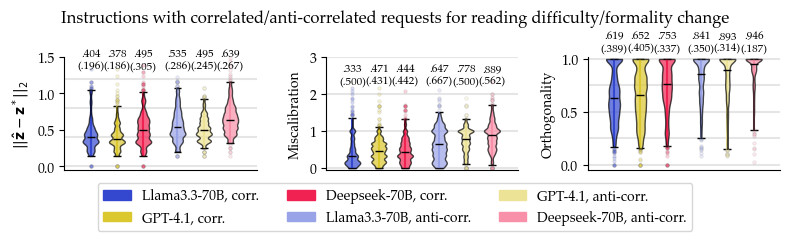

In [48]:
names = [
    "Llama3.3-70B, corr.", "GPT-4.1, corr.", "Deepseek-70B, corr.",
    "Llama3.3-70B, anti-corr.", "GPT-4.1, anti-corr.", "Deepseek-70B, anti-corr.",
]
inst_by_corr = decompose_entangled(main_models[4], main_models[8], main_models[-1])

#vanilla_colors = interpolate_colors("#68adbd", "#3448cf", 2)
#corr_colors = interpolate_colors("#a6e6f5", "#7986e0", 3)
#anticorr_colors = interpolate_colors("#c7a46b", "#d4c86e", 3)

def brighten(hex_color, amount=0.5):
    hex_color = hex_color.lstrip("#")
    r, g, b = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]
    r = int(r + (255 - r) * amount)
    g = int(g + (255 - g) * amount)
    b = int(b + (255 - b) * amount)
    return f"#{r:02x}{g:02x}{b:02x}"

llama_colors = interpolate_colors("#226287", "#3448cf", 3) 
gpt_colors = interpolate_colors("#6e563b", "#dbc72e", 4)[1:]
deepseek_colors = interpolate_colors("#ba3c23", "#f02252", 2)

corr_colors = [llama_colors[-1], gpt_colors[-1], deepseek_colors[-1]]
anticorr_colors = [brighten(c) for c in corr_colors]

_ = plot_steerability_metrics(
    inst_by_corr,
    corr_colors + anticorr_colors,
    names,
    -0.22,
    group_sizes=[3, 3],
    suptitle="Instructions with correlated/anti-correlated requests for reading difficulty/formality change", # between requested changes",
    suptitle_y=0.87,
    legend_title="",
    figsize=(8., 2.1),
    save="entanglement",
    #steering_goals=["reading_difficulty", "formality"],
    #control=staged[0],
    normalize=True,
    cut_points=CUT_POINTS,
    ncols=3,
    steer_height=1.3, miscal_height=2.2, ortho_height=1.05,
)


In [2]:
def print_main_metrics(df, steering_goals=["reading_difficulty", "formality"], control=None):
    steering_err = get_dist_to_goal(df, steering_goals=steering_goals, cut_points=CUT_POINTS)
    miscal = get_miscalibration(df, steering_goals=steering_goals, cut_points=CUT_POINTS)
    ortho = get_orthogonality(df, steering_goals=steering_goals, cut_points=CUT_POINTS)

    if control is not None:
        control_steering_err = get_dist_to_goal(control, steering_goals=steering_goals, cut_points=CUT_POINTS)
        control_miscal = get_miscalibration(control, steering_goals=steering_goals, cut_points=CUT_POINTS)
        control_ortho = get_orthogonality(control, steering_goals=steering_goals, cut_points=CUT_POINTS)
        steering_err = steering_err - control_steering_err
        miscal = miscal - control_miscal
        ortho = ortho - control_ortho
        print(f"Improvement in steering err.: {np.median(steering_err):.3f}±{np.percentile(steering_err, 75) - np.percentile(steering_err, 25):.3f}")
        print(f"Improvement in miscalibration: {np.median(miscal):.3f}±{np.percentile(miscal, 75) - np.percentile(miscal, 25):.3f}")
        print(f"Improvement in orthogonality: {np.median(ortho):.3f}±{np.percentile(ortho, 75) - np.percentile(ortho, 25):.3f}")
    else:
        print(f"Steering err.: {np.median(steering_err):.3f}±{np.percentile(steering_err, 75) - np.percentile(steering_err, 25):.3f}")
        print(f"Miscalibration: {np.median(miscal):.3f}±{np.percentile(miscal, 75) - np.percentile(miscal, 25):.3f}")
        print(f"Orthogonality: {np.median(ortho):.3f}±{np.percentile(ortho, 75) - np.percentile(ortho, 25):.3f}")


print_main_metrics(pd.read_csv("./judge_results/grounding/ortho_only_judged.csv"))

NameError: name 'pd' is not defined

In [72]:
print_main_metrics(pd.read_csv("./judge_results/grounding/vanilla_rl_judged.csv"))

Steering err.: 0.119±0.135
Miscalibration: 0.294±0.391
Orthogonality: 0.160±0.292


In [73]:
print_main_metrics(pd.read_csv("./judge_results/grounding/tuning_stage_0_judged.csv"))

Steering err.: 0.300±0.150
Miscalibration: 0.986±0.464
Orthogonality: 0.147±0.328


In [67]:
print_main_metrics(post_process_oracle(pd.read_csv("./judge_results/grounding/meta_test_b128_judged.csv"), steering_goals=["reading_difficulty", "formality"]))

Steering err.: 0.210±0.168
Miscalibration: 0.683±0.539
Orthogonality: 0.121±0.282


400/400 rewrites passed groudnedness check | 0 flagged | 0 overruled
400/400 rewrites passed groudnedness check | 0 flagged | 0 overruled
400/400 rewrites passed groudnedness check | 0 flagged | 0 overruled


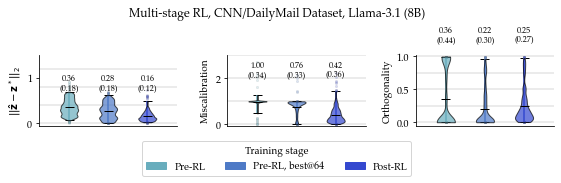

In [58]:
plot_steerability_metrics(
    [df[df["source"] == 'Dataset: ccdv/cnn_dailymail/3.0.0/validation'] for df in staged],
    interpolate_colors("#68adbd", "#3448cf", len(names)),
    names,
    -0.25,
    group_sizes=len(names),
    suptitle="Multi-stage RL, CNN/DailyMail Dataset, Llama-3.1 (8B)",
    suptitle_y=0.85,
    legend_title="Training stage",
    figsize=(8., 2.2),
    save="steer_tuning_cnn_dailymail",
    steering_goals=["reading_difficulty", "formality"],
    #control=staged[0],
    normalize=True,
)

160/160 rewrites passed groudnedness check | 0 flagged | 0 overruled
160/160 rewrites passed groudnedness check | 0 flagged | 0 overruled
160/160 rewrites passed groudnedness check | 0 flagged | 0 overruled


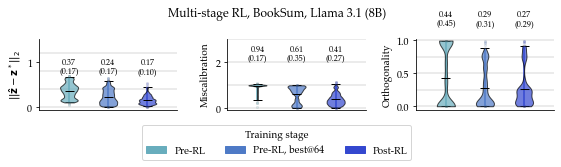

In [55]:
plot_steerability_metrics(
    [df[df["source"] == 'Dataset: kmfoda/booksum/validation'] for df in staged],
    interpolate_colors("#68adbd", "#3448cf", len(names)),
    names,
    -0.25,
    group_sizes=len(names),
    suptitle="Multi-stage RL, BookSum, Llama 3.1 (8B)",
    suptitle_y=0.75,
    legend_title="Training stage",
    figsize=(8., 2.2),
    save="steer_tuning_booksum",
    steering_goals=["reading_difficulty", "formality"],
    #control=staged[0],
    normalize=True,
)

464/464 rewrites passed groudnedness check | 0 flagged | 0 overruled
464/464 rewrites passed groudnedness check | 0 flagged | 0 overruled
464/464 rewrites passed groudnedness check | 0 flagged | 0 overruled


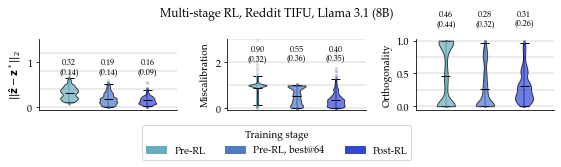

In [56]:
plot_steerability_metrics(
    [df[df["source"] == 'Dataset: ctr4si/reddit_tifu/short/train'] for df in staged],
    interpolate_colors("#68adbd", "#3448cf", len(names)),
    names,
    -0.25,
    group_sizes=len(names),
    suptitle="Multi-stage RL, Reddit TIFU, Llama 3.1 (8B)",
    suptitle_y=0.75,
    legend_title="Training stage",
    figsize=(8., 2.2),
    save="steer_tuning_reddit",
    steering_goals=["reading_difficulty", "formality"],
    #control=staged[0],
    normalize=True,
)

In [7]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

import numpy as np

smoothing = SmoothingFunction()

bleu_results = {}
raw_results = {}
for name, df in zip(names, staged):
    print(name)
    ref_list = [[word_tokenize(r)] for r in df["text"]]  # list of reference lists
    cand_list = [word_tokenize(c) for c in df["llm_response"]]
    bleu_scores = pd.Series([sentence_bleu(ref, cand, smoothing_function=smoothing.method1) for ref, cand in zip(ref_list, cand_list)])
    bleu_results[name] = {
        "all": bleu_scores.mean(),
    }
    raw_results[name] = bleu_scores
    for dataset in df["source"].unique():
        bleu_results[name][dataset] = bleu_scores.loc[df["source"] == dataset].mean()



Pre-RL
Pre-RL, best@128
Post-RL


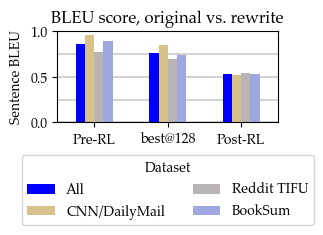

In [8]:

df = pd.DataFrame(bleu_results).rename(lambda x: x.split(": ")[-1])
df = df.sort_index()
df.index = ["All", "CNN/DailyMail", "Reddit TIFU", "BookSum"]
df = df.rename({"Pre-RL, best@128": "best@128"}, axis=1)

# Plot
ax = df.T.plot(kind='bar', figsize=(3.2, 2.8), color=["blue"] + interpolate_colors("#d9c18b", "#9ea8de", 3))
ax.set_title("BLEU score, original vs. rewrite")

ax.hlines([0.0, 0.25, 0.5, 0.75], xmin=-0.5, xmax=len(df.columns), color="lightgray", zorder=-999)

ax.set_ylabel("Sentence BLEU")
plt.legend(title="Dataset", ncols=2, loc="upper center", bbox_to_anchor=(0.5, -0.28))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("./figures/sentence_bleu_post_rl.pdf")
plt.show()


In [9]:
df

Pre-RL  best@128   Post-RL
All            0.863649  0.760575  0.529285
CNN/DailyMail  0.957611  0.851698  0.521380
Reddit TIFU    0.772768  0.689209  0.536787
BookSum        0.892298  0.739728  0.527293

<Axes: xlabel='bleu', ylabel='error'>

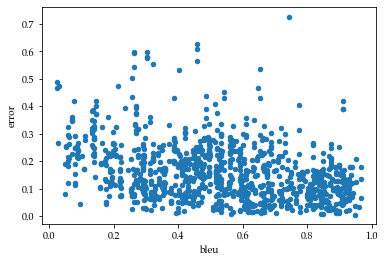

In [86]:
pd.concat([
    raw_results["Post-RL"].rename("bleu"),
    pd.Series(get_dist_to_goal(staged[-1], steering_goals=["reading_difficulty", "formality"]), name="error")
    ], axis=1).plot(kind="scatter", x="bleu", y="error")

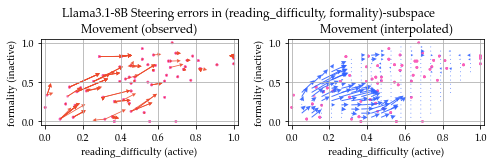

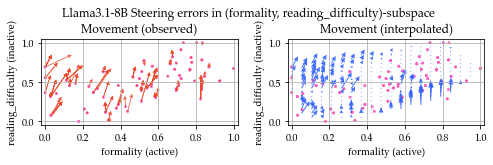

In [59]:
get_pairwise_flows(staged[0], "Llama3.1-8B", exp_name="llama_pre_rl", steering_goals=["reading_difficulty", "formality"])

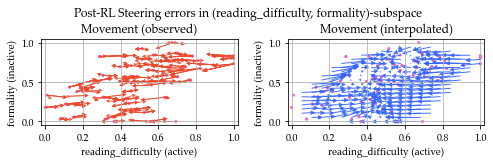

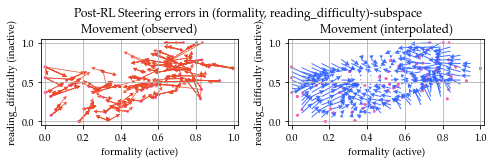

In [25]:
get_pairwise_flows(staged[-1], "Post-RL", exp_name="llama_post_rl", steering_goals=["reading_difficulty", "formality"])

135
0
0
0
0
0
0
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1020/1024 rewrites passed groudnedness check | 1 flagged | 3 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled


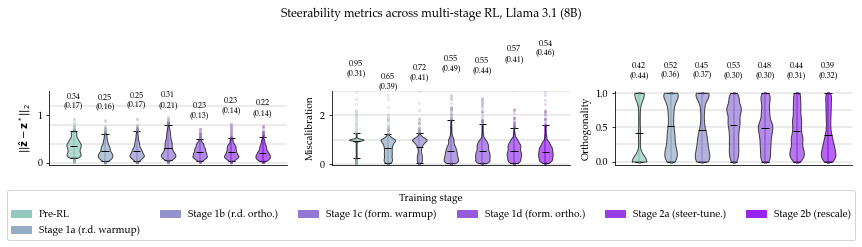

In [47]:
from functools import reduce

multi_stage = [
    pd.read_csv("./judge_results/grounding/tuning_stage_0_judged.csv"),
    pd.read_csv("./judge_results/grounding/tuning_stage_1a_judged.csv"),
    pd.read_csv("./judge_results/grounding/tuning_stage_1b_judged.csv"),
    pd.read_csv("./judge_results/grounding/tuning_stage_1c_judged.csv"),
    pd.read_csv("./judge_results/grounding/tuning_stage_1d_judged.csv"),
    pd.read_csv("./judge_results/grounding/tuning_stage_2a_judged.csv"),
    pd.read_csv("./judge_results/grounding/tuning_stage_2b_judged.csv"),
]

for df in multi_stage:
     print((df["text"] == df["llm_response"]).sum())
trivial_repeat = reduce(np.logical_or, [(df["text"] == df["llm_response"]) for df in multi_stage])
multi_stage_filtered = [df.loc[~trivial_repeat] for df in multi_stage]


names = ["Pre-RL", "Stage 1a (r.d. warmup)", "Stage 1b (r.d. ortho.)", "Stage 1c (form. warmup)", "Stage 1d (form. ortho.)",
         "Stage 2a (steer-tune.)", "Stage 2b (rescale)",
         #"Stage 2A (Pareto)",
         ]

plot_steerability_metrics(
    multi_stage,
    interpolate_colors("#93c9be", "#9624ed", len(names)),
    names,
    -0.3,
    group_sizes=len(names),
    suptitle="Steerability metrics across multi-stage RL, Llama 3.1 (8B)",
    suptitle_y=0.8,
    legend_title="Training stage",
    figsize=(12., 3.),
    save="steer_tuning_by_stage",
    steering_goals=["reading_difficulty", "formality"],
    #control=staged[0],
    normalize=True,
)

In [35]:

def plot_error_by_goal(results, colors, names, legend_y, group_sizes=1, control=None,
                          legend_title="Model", save=None, steering_goals=STEERING_GOALS,
                          exclude_degenerate=True, wide=True,
                          figsize=(8, 2), suptitle=None, suptitle_y=0.9, normalize=True):
    handles = []
    positions = compute_bar_positions(len(results), group_sizes)

    if wide:
        fig, axs = plt.subplots(1, len(steering_goals), figsize=figsize)
    else:
        fig, axs = plt.subplots(len(steering_goals), 1, figsize=figsize)

    sup = None
    if suptitle is not None:
        sup = fig.suptitle(suptitle, y=suptitle_y)

    for ax, goal in zip(axs, steering_goals):
        ax.set_ylabel(f"Error, {goal}")
        ax.set_xlabel("")

    if control is not None:
        control_dist = get_dist_to_goal(control, steering_goals=steering_goals, by_goal=True)


    for i, (df, color) in enumerate(zip(results, colors)):
        if exclude_degenerate:
            df = get_grounded_subset(df)
        dist = get_dist_to_goal(df, steering_goals=steering_goals, by_goal=True)
        amt_moved = get_dist_from_source(df, by_goal=True, steering_goals=steering_goals)
        if control is not None:
            dist = np.square(dist - control_dist)
            print("% improved, steerability:", (dist < 0).mean())

        for j, goal in enumerate(steering_goals):
            create_violin_subplot(np.abs(dist[goal]), positions[i], color, axs[j])

        patch = mpatches.Patch(color=color)
        handles.append(patch)

    for ax in axs:
        ax.tick_params(axis="x", length=0)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xlim((min(positions) - 1, max(positions) + 1))
        ax.set_xticklabels([])


        ax.set_ylim((0, 1.))
        ax.hlines([0., 0.2, 0.4, 0.6, 0.8, 1.0], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)


    #fig.suptitle(suptitle)
    lgd = fig.legend(
        handles,
        names, # + ["Perfect steerability"],
        ncols=min(len(results) + 1, 7 if wide else 4),
        loc="lower center",
        bbox_to_anchor=(0.5, legend_y),
        title=legend_title,
    )
    fig.tight_layout()
    if save is not None:
        fig.savefig(f"figures/{save}.pdf", bbox_inches="tight", bbox_extra_artists=(lgd, sup))
    fig.show()

1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1020/1024 rewrites passed groudnedness check | 1 flagged | 3 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled
1024/1024 rewrites passed groudnedness check | 0 flagged | 0 overruled


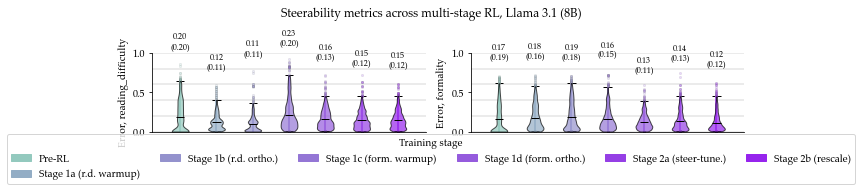

In [50]:
plot_error_by_goal(
    multi_stage,
    interpolate_colors("#93c9be", "#9624ed", len(names)),
    names,
    -0.25,
    group_sizes=len(names),
    suptitle="Steerability metrics across multi-stage RL, Llama 3.1 (8B)",
    suptitle_y=0.9,
    legend_title="Training stage",
    figsize=(9., 2.2),
    save="steer_tuning_by_stage_filtered",
    steering_goals=["reading_difficulty", "formality"],
    #control=staged[0],
)

In [44]:
pre_rl_df = get_dist_to_goal(staged[0], steering_goals=["reading_difficulty", "formality"], by_goal=True)
post_rl_df = get_dist_to_goal(staged[1], steering_goals=["reading_difficulty", "formality"], by_goal=True)
diffs = (pre_rl_df - post_rl_df)
goal_idx = diffs["formality"].idxmax()
goal_idx, diffs["formality"].max(), pre_rl_df.iloc[goal_idx], post_rl_df.iloc[goal_idx]

(977,
 0.43153916905484846,
 reading_difficulty    0.479413
 formality             0.047834
 Name: 977, dtype: float64,
 reading_difficulty   -0.055240
 formality            -0.383705
 Name: 977, dtype: float64)

In [28]:
def get_best_by_goal(df1, df2, goal, steering_goals=STEERING_GOALS):
    if goal == "orthogonality":
        pre = get_orthogonality(df1, steering_goals=steering_goals, normalize=False)
        post = get_orthogonality(df2, steering_goals=steering_goals, normalize=False)
        goal_idx = np.argmax(pre - post)
    elif goal == "copy-paste":
        copy_pasted_idx = df1[df1["text"] == df1["llm_response"]].index
        candidate = df2.loc[copy_pasted_idx]
        ref_list = [[word_tokenize(r)] for r in candidate["text"]]  # list of reference lists
        cand_list = [word_tokenize(c) for c in candidate["llm_response"]]
        bleu_scores = pd.Series([sentence_bleu(ref, cand, smoothing_function=smoothing.method1) for ref, cand in zip(ref_list, cand_list)], index=candidate.index)
        goal_idx = bleu_scores.idxmin()
    else:
        pre_df = get_dist_to_goal(df1, steering_goals=steering_goals, by_goal=True)
        post_df = get_dist_to_goal(df2, steering_goals=steering_goals, by_goal=True)
        diffs = (pre_df - post_df).abs()
        goal_idx = diffs[goal].idxmax()
    orig = df1.iloc[goal_idx]["text"]
    inst = df1.iloc[goal_idx]["instruction"]
    pre_response = df1.iloc[goal_idx]["llm_response"]
    post_response = df2.iloc[goal_idx]["llm_response"]
    print("Chose index:", goal_idx)
    for gg in steering_goals:
        print(f"Goal {gg}:", df1.iloc[goal_idx][f"source_{gg}"], "->",
            df1.iloc[goal_idx][f"target_{gg}"], df1.iloc[goal_idx][f"output_{gg}"], "vs.",
            df2.iloc[goal_idx][f"output_{gg}"])
    return pd.DataFrame([
        orig, inst, pre_response, post_response,
    ]).T.style.set_properties(**{
        'white-space': 'normal',
        'word-wrap': 'break-word',
        'max-width': '300px'
    })



get_best_by_goal(results_2d[0], results_2d[1], "orthogonality", steering_goals=["reading_difficulty", "formality"])




Chose index: 999
Goal reading_difficulty: 0.3168316831683168 -> 0.0499660748952571 1.0 vs. 0.2970297029702969
Goal formality: 0.0292433464969357 -> 0.6593222042885721 0.8212103453581641 vs. 0.4637189133076471


In [14]:
results_2d[1].iloc[999]

Unnamed: 0                                                                     999
original_index                                                                6109
text                             well this happened last night past midnight. a...
source                                     Dataset: ctr4si/reddit_tifu/short/train
reading_difficulty                                                             6.0
formality                                                                41.212654
source_reading_difficulty                                                 0.316832
source_formality                                                          0.029243
sampling_weights                                                          0.000123
sampling_weights_mean                                                     1.022472
delta_reading_difficulty                                                 -0.266866
delta_formality                                                           0.630079
targ

In [39]:
print(form.get_pos_freqs(results_2d[0].iloc[999]["text"]))

print(form.get_pos_freqs(results_2d[0].iloc[999]["llm_response"]))

print(form.get_pos_freqs(results_2d[1].iloc[999]["llm_response"]))

{'NOUN': 8.787346221441124, 'ADJ': 4.393673110720562, 'ADP': 11.599297012302284, 'ARTICLE': 4.21792618629174, 'PRON': 20.913884007029875, 'VERB': 17.223198594024606, 'ADV': 8.084358523725834, 'INTJ': 0.35149384885764495}
{'NOUN': 22.037037037037038, 'ADJ': 6.111111111111111, 'ADP': 15.925925925925927, 'ARTICLE': 10.555555555555555, 'PRON': 8.703703703703704, 'VERB': 13.88888888888889, 'ADV': 4.074074074074074, 'INTJ': 0.0}
{'NOUN': 14.814814814814813, 'ADJ': 4.545454545454546, 'ADP': 14.814814814814813, 'ARTICLE': 7.744107744107744, 'PRON': 13.973063973063974, 'VERB': 17.003367003367003, 'ADV': 3.3670033670033668, 'INTJ': 0.16835016835016833}


In [45]:
import textstat

print(textstat.avg_syllables_per_word(results_2d[0].iloc[999]["llm_response"]))
print(textstat.avg_syllables_per_word(results_2d[0].iloc[999]["text"]))
print(textstat.avg_syllables_per_word(results_2d[1].iloc[999]["llm_response"]))


print(textstat.words_per_sentence(results_2d[0].iloc[999]["llm_response"]))
print(textstat.words_per_sentence(results_2d[0].iloc[999]["text"]))
print(textstat.words_per_sentence(results_2d[1].iloc[999]["llm_response"]))

1.7
1.1
1.4
22.5
21.96153846153846
12.479166666666666


In [35]:
get_dist_to_goal(staged[2], steering_goals=["reading_difficulty", "formality"])[409]

0.2673517224197569

In [27]:
from nltk import word_tokenize

best_copy_paste = get_best_by_goal(staged[0], staged[-1], "copy-paste", steering_goals=["reading_difficulty", "formality"])
best_copy_paste

Chose index: 409
Goal reading_difficulty: 0.7029702970297029 -> 0.7029702970297029 0.7029702970297028 vs. 0.9702970297029702
Goal formality: 0.5676512594676967 -> 0.0036553356954274 0.567651259467697 vs. 0.0


In [33]:
staged[2].iloc[409]

Unnamed: 0                                                                     409
original_index                                                                 681
text                             She's suddenly been thrust into the limelight ...
source                                Dataset: ccdv/cnn_dailymail/3.0.0/validation
reading_difficulty                                                             9.9
formality                                                                56.691729
source_reading_difficulty                                                  0.70297
source_formality                                                          0.567651
sampling_weights                                                          0.000134
sampling_weights_mean                                                     1.114494
delta_reading_difficulty                                                       NaN
delta_formality                                                          -0.563996
targ

In [110]:
import textstat

textstat.words_per_sentence(staged[2].iloc[409]["llm_response"])

33.0

In [114]:
textstat.avg_syllables_per_word(staged[2].iloc[409]["llm_response"])

1.3

In [38]:
from goals import Formality

form = Formality()

print(form.get_pos_freqs(staged[0].iloc[409]["llm_response"]))
print(form.get_pos_freqs(staged[2].iloc[409]["llm_response"]))

Unable to import empath.
Failed to import transformers -- check torch version and torchvision compatibility Failed to import transformers.pipelines because of the following error (look up to see its traceback):
partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)


/data2/ctrenton/miniconda3/envs/steerability/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


{'NOUN': 18.1203007518797, 'ADJ': 6.165413533834586, 'ADP': 12.556390977443609, 'ARTICLE': 6.616541353383458, 'PRON': 11.278195488721805, 'VERB': 14.43609022556391, 'ADV': 4.285714285714286, 'INTJ': 0.07518796992481204}
{'NOUN': 9.767441860465116, 'ADJ': 8.372093023255815, 'ADP': 5.813953488372093, 'ARTICLE': 1.8604651162790697, 'PRON': 17.441860465116278, 'VERB': 7.906976744186046, 'ADV': 14.186046511627906, 'INTJ': 7.441860465116279}


In [64]:
best_ortho = get_best_by_goal(staged[0], staged[1], "orthogonality", steering_goals=["reading_difficulty", "formality"])
best_ortho

Goal reading_difficulty: 0.5148514851485148 -> 0.5148514851485148 0.5049504950495048 vs. 0.5148514851485148
Goal formality: 0.9257700148162168 -> 0.775956006436217 0.9257700148162172 vs. 0.8624997191783526


In [49]:
import spacy
nlp = spacy.load("en_core_web_sm")

def pos_tag(text):
    doc = nlp(text)
    for token in doc:
        print(f"{token.text:15} {token.pos_:10} ({token.tag_})")

/data2/ctrenton/miniconda3/envs/steerability/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [56]:
pos_tag(best_formality.data[3].item())

So              ADV        (RB)
like            INTJ       (UH)
,               PUNCT      (,)
the             DET        (DT)
families        NOUN       (NNS)
of              ADP        (IN)
these           DET        (DT)
two             NUM        (CD)
Aussie          PROPN      (NNP)
blokes          NOUN       (NNS)
who             PRON       (WP)
are             AUX        (VBP)
total           ADJ        (JJ)
drug            NOUN       (NN)
smugglers       NOUN       (NNS)
are             AUX        (VBP)
totally         ADV        (RB)
freaking        VERB       (VBG)
out             ADP        (RP)
right           ADV        (RB)
now             ADV        (RB)
,               PUNCT      (,)
and             CCONJ      (CC)
they            PRON       (PRP)
're             AUX        (VBP)
on              ADP        (IN)
their           PRON       (PRP$)
way             NOUN       (NN)
to              ADP        (IN)
this            DET        (DT)
super           ADJ        (JJ)

In [49]:
from scipy.stats import wilcoxon
score_before = get_dist_to_goal(staged[0], steering_goals=["reading_difficulty", "formality"])
score_after = get_dist_to_goal(staged[3], steering_goals=["reading_difficulty", "formality"]) 
stat, p = wilcoxon(score_after, score_before, alternative='less')  # less = score went dow
print(stat, p)

144068.0 5.427104740686241e-11


In [50]:
mean_diff = np.mean(score_after - score_before)
std_diff = np.std(score_after - score_before, ddof=1)
cohens_d = mean_diff / std_diff
print(cohens_d)

-0.22357439152702344


# Goal flow diagrams

In [39]:
from scipy.interpolate import griddata

def grab_subspace(df, *args, unspecified=True, specified_first=False, steering_goals=STEERING_GOALS):
    xy = df[[f"source_{g}" for g in args]] # can also ask for deltas
    source_df = get_dist_from_source(df, by_goal=True, steering_goals=steering_goals)
    dxdy = source_df[list(args)] # output - source
    dxdy_ideal = get_dist_requested(df, by_goal=True, steering_goals=steering_goals)[list(args)].fillna(0.)
    
    dxdy.columns = [f"d_{g}" for g in args]
    dxdy_ideal.columns = [f"d*_{g}" for g in args]
    final = pd.concat([xy, dxdy, dxdy_ideal], axis=1)
    if unspecified:
        final = final.loc[dxdy_ideal.sum(axis=1) == 0]
    elif specified_first:
        final = final.loc[(dxdy_ideal[f"d*_{args[0]}"].abs() > 0) & (dxdy_ideal[f"d*_{args[1]}"] == 0)] # TODO: make this work for >1 goal
    final.columns = ["x1", "x2", "dx1", "dx2", "dx1_ideal", "dx2_ideal"]
    return final

def flow_diagram(df, xname, yname, model_name, unspecified=False, specified_first=True, model_display_name=None,
                 mode="movement", drop_close=None, save=False, exp_name=None, steering_goals=STEERING_GOALS, flow_only=False):
    if mode not in ["movement", "distance_to_goal"]:
        raise ValueError(f"Unuspported mode: {mode}")

    if mode == "movement":
        name = "Movement"
    else:
        name = "Distance to goal"
    
    subspace = grab_subspace(df, xname, yname, unspecified=unspecified, specified_first=specified_first, steering_goals=steering_goals)
    
    # Create a subplot with two plots: raw data and interpolated data
    if flow_only: 
        fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
        movement_ax, flow_ax = None, ax
    else:
        fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
        movement_ax, flow_ax = ax
    suptitle = f"({xname}, {yname})-flow\n{model_name}"
    if model_display_name is not None:
        suptitle += f"\nModel: {model_display_name}"
    fig.suptitle(suptitle, y=0.9)
    
    xlabel = f"{xname} (active)"
    ylabel = f"{yname} (inactive)"

    z0_size = 10
    z0_color = "#fa5fbb"
    movement_color = "#ed492b"
    rawwidth = 5
    headwidth = 5
    arrowwidth = 0.004
    flow_width = 0.005
    
    if movement_ax is not None:
        movement_ax.scatter(subspace["x1"], subspace["x2"], marker=".", alpha=0.5, edgecolors=z0_color, facecolors="none", s=z0_size)
        if mode == "movement":
            movement_ax.quiver(subspace["x1"], subspace["x2"], subspace["dx1"], subspace["dx2"], scale=5, 
                    color=movement_color, alpha=0.9, headwidth=rawwidth, width=arrowwidth)
        else:
            x1, x2 = subspace["x1"], subspace["x2"]
            dx1, dx2 = subspace["dx1_ideal"] - subspace["dx1"], subspace["dx2_ideal"] - subspace["dx2"]
            if drop_close is not None:
                err_norm = np.sqrt(dx1 ** 2 + dx2 ** 2)
                err_mask = err_norm > drop_close
                x1, x2, dx1, dx2 = x1[err_mask], x2[err_mask], dx1[err_mask], dx2[err_mask]
            
            movement_ax.quiver(x1, x2, dx1, dx2, scale=10, color=movement_color,
                        alpha=0.9, headwidth=rawwidth, width=arrowwidth)
        
        movement_ax.set_title(f"{name} (observed)")
        movement_ax.set_xlabel(xlabel)
        movement_ax.set_ylabel(ylabel)
        movement_ax.set_xlim((-0.02, 1.02))
        movement_ax.set_ylim((-0.05, 1.05))
        movement_ax.grid(True)


    grid_x, grid_y = np.meshgrid(np.linspace(min(subspace["x1"]), max(subspace["x1"]), 20),
                                 np.linspace(min(subspace["x2"]), max(subspace["x2"]), 20))

    if mode == "movement":
        grid_u = griddata((subspace["x1"], subspace["x2"]), subspace["dx1"], (grid_x, grid_y), method='linear')
        grid_v = griddata((subspace["x1"], subspace["x2"]), subspace["dx2"], (grid_x, grid_y), method='linear')
    else:
        grid_u = griddata((subspace["x1"], subspace["x2"]), subspace["dx1_ideal"] - subspace["dx1"], (grid_x, grid_y), method='linear')
        grid_v = griddata((subspace["x1"], subspace["x2"]), subspace["dx2_ideal"] - subspace["dx2"], (grid_x, grid_y), method='linear')

    
    # Plot the interpolated data
    flow_ax.scatter(subspace["x1"], subspace["x2"], marker=".", alpha=0.5,
                    edgecolors=z0_color, facecolors="none", s=z0_size)

    flow_ax.quiver(grid_x, grid_y, grid_u, grid_v, scale=5, color='#3061ff', headwidth=headwidth, width=flow_width, alpha=0.9)
    flow_ax.set_title(f"{name} (interpolated)")
    flow_ax.set_xlabel(xlabel)
    flow_ax.set_ylabel(ylabel)
    flow_ax.set_xlim((-0.02, 1.02))
    flow_ax.set_ylim((-0.05, 1.05))
    flow_ax.grid(True)

    plt.tight_layout()
    if save:
        plt.savefig(f"./figures/flows/{exp_name}_{mode}_flow_{xname}_{yname}_subspace.pdf")
    plt.show()
    return subspace


from itertools import product

def get_pairwise_flows(df, model_name, steering_goals=STEERING_GOALS, exp_name="", flow_only=False):
    for x, y in product(steering_goals, steering_goals):
        if x != y:
            flow_diagram(df, x, y, model_name, specified_first=True, unspecified=False,
                         mode="movement", save=True, exp_name=exp_name, steering_goals=steering_goals, flow_only=flow_only)

    

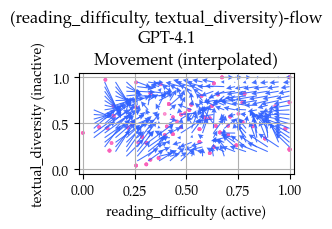

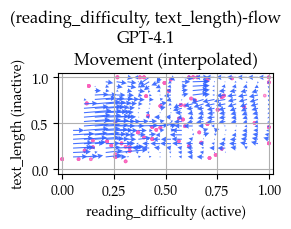

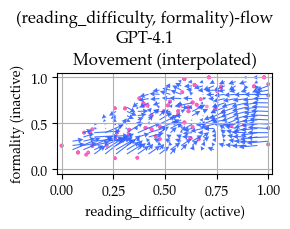

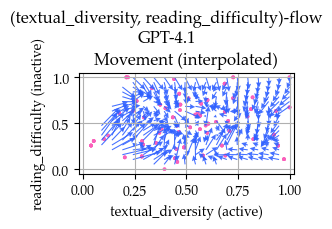

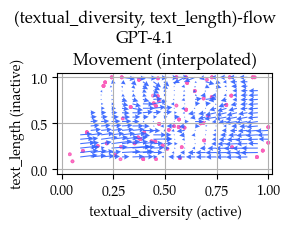

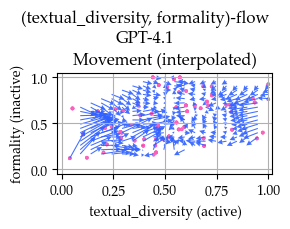

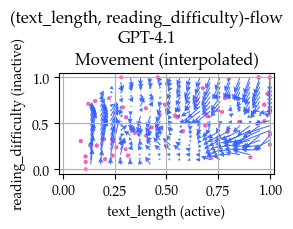

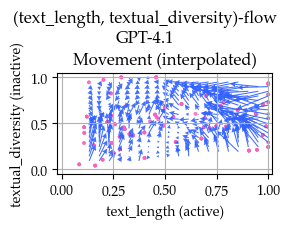

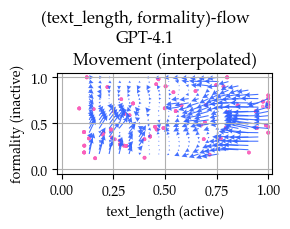

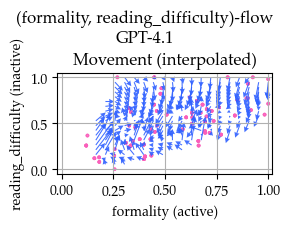

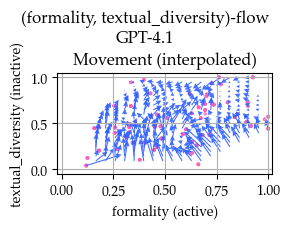

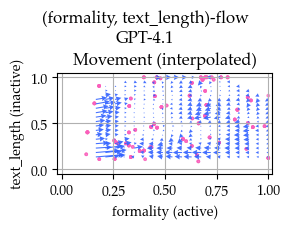

In [40]:
get_pairwise_flows(main_models[8], "GPT-4.1", exp_name="gpt4_1_negprompt", flow_only=True)

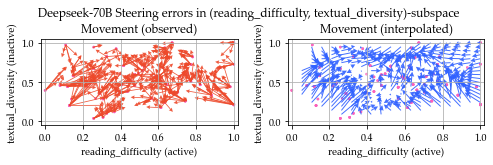

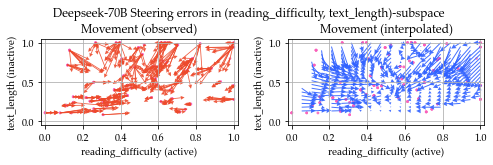

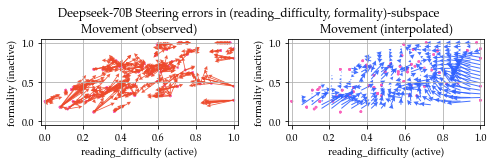

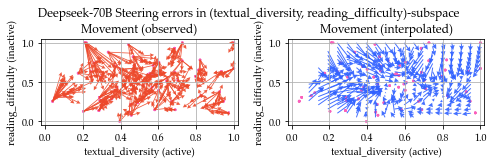

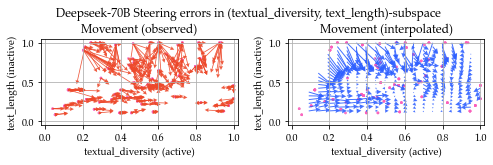

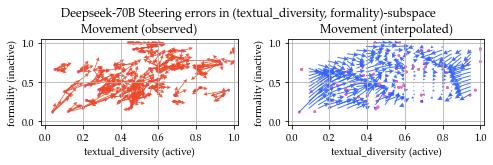

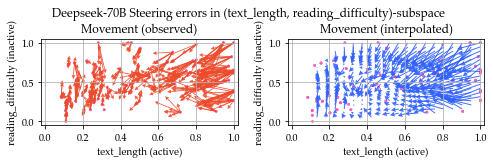

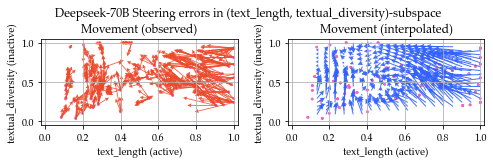

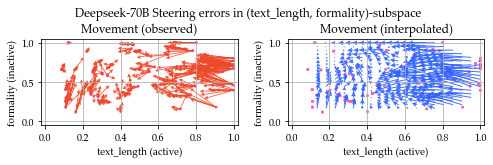

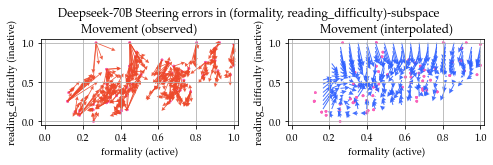

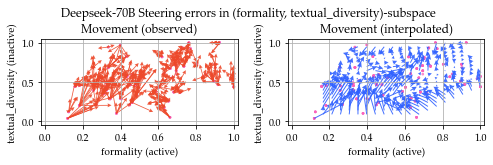

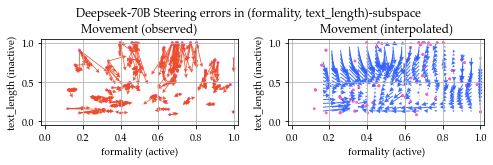

In [50]:
get_pairwise_flows(models[-1], "Deepseek-70B", exp_name="deepseek_negprompt")

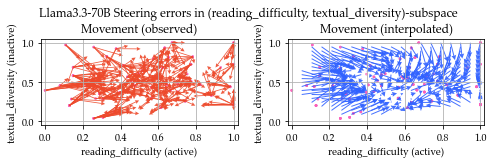

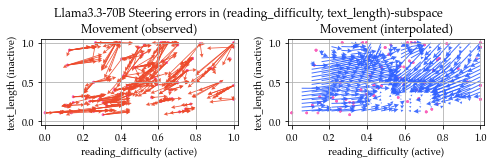

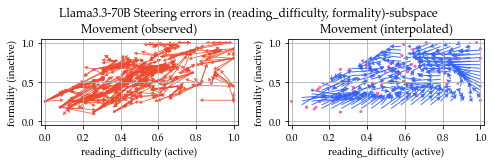

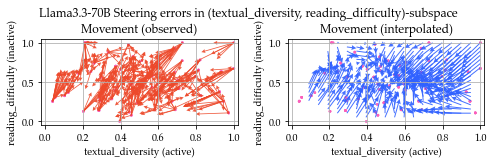

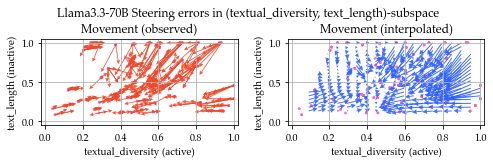

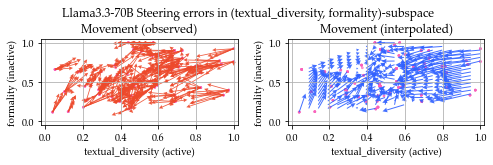

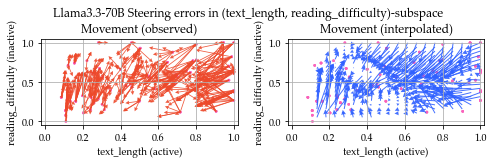

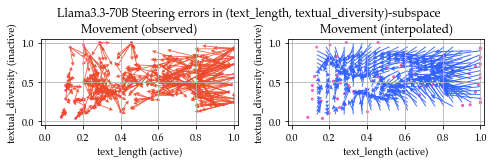

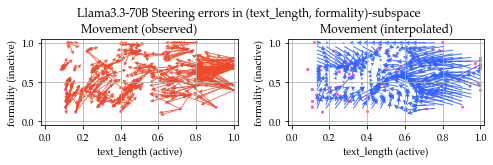

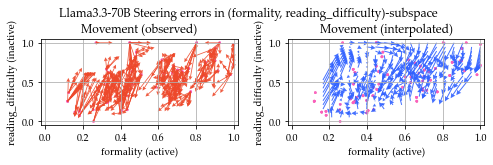

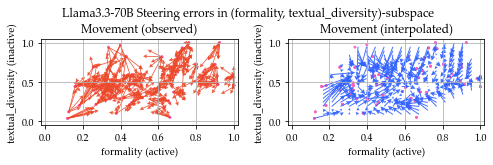

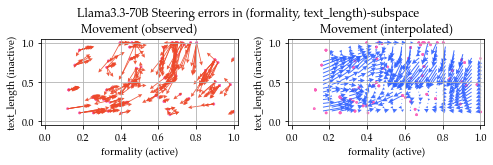

In [51]:
get_pairwise_flows(models[4], "Llama3.3-70B", exp_name="llama3_70b_negprompt")

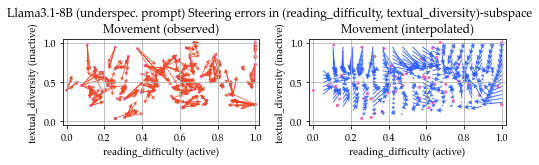

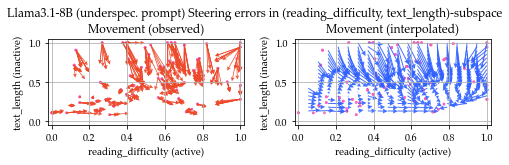

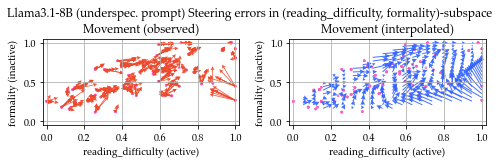

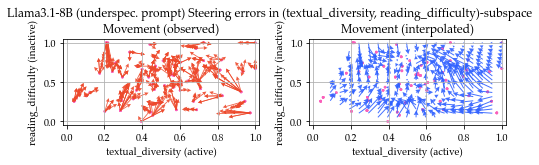

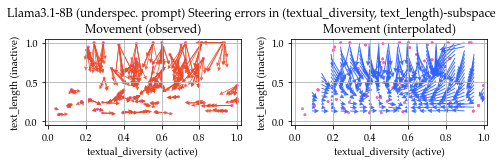

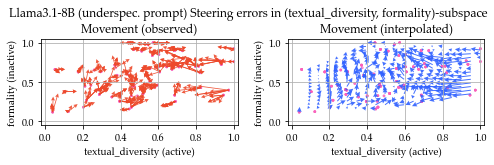

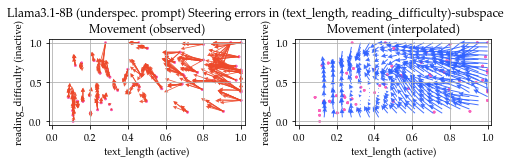

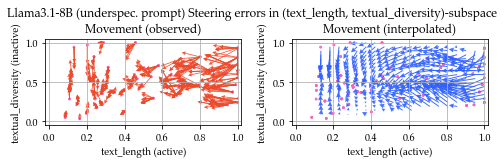

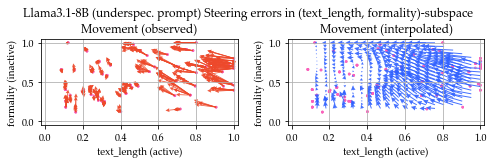

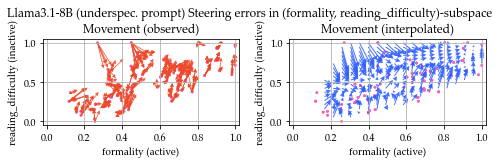

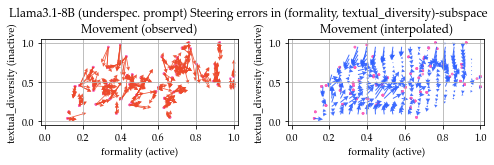

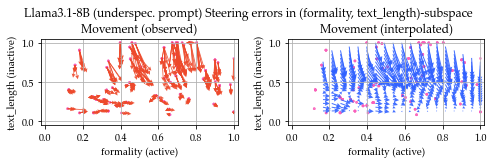

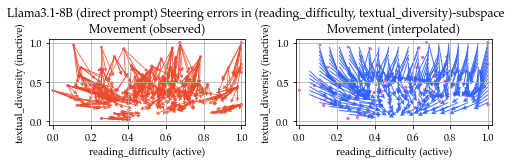

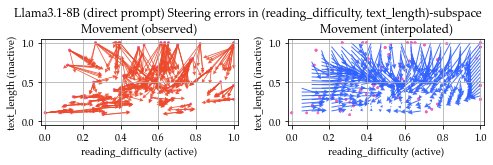

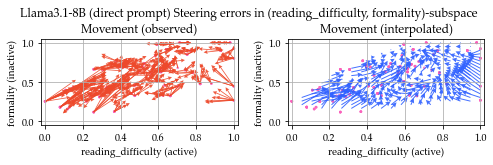

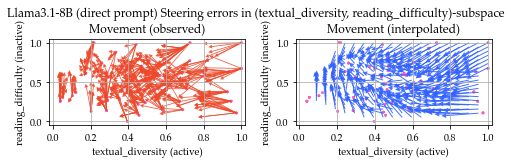

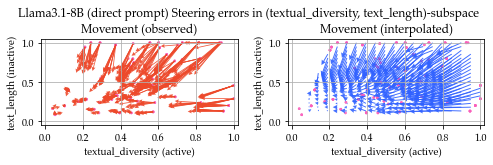

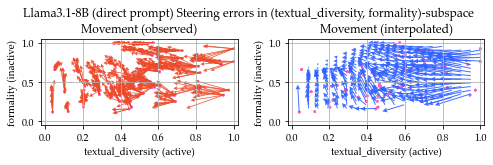

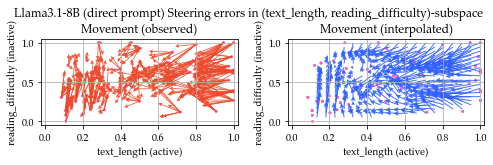

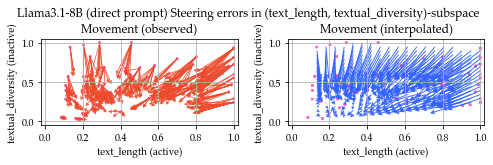

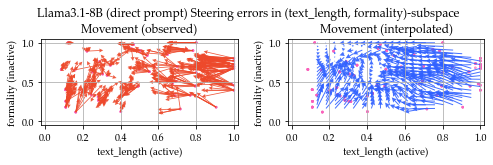

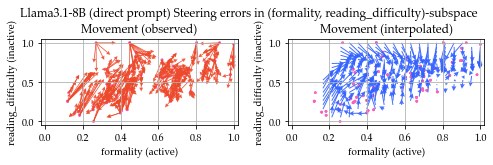

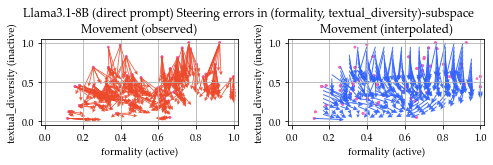

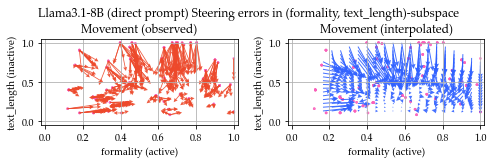

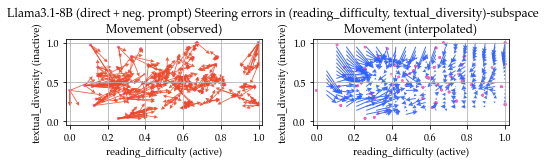

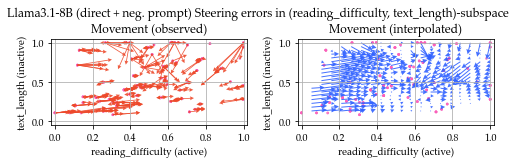

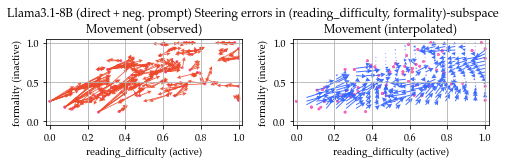

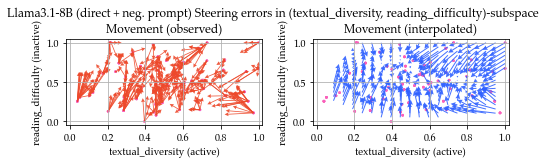

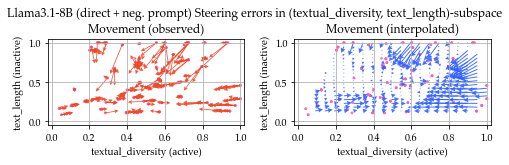

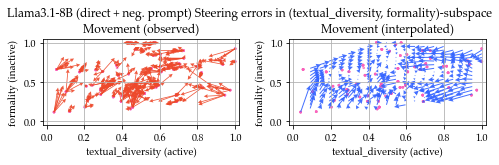

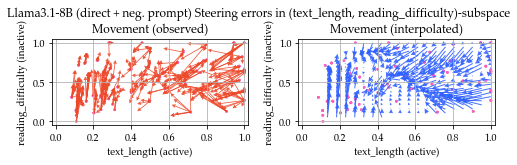

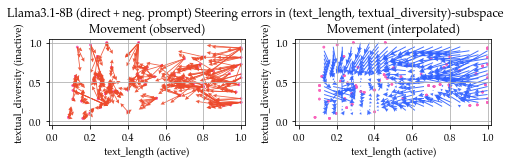

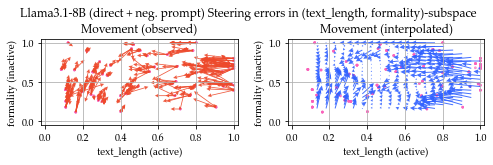

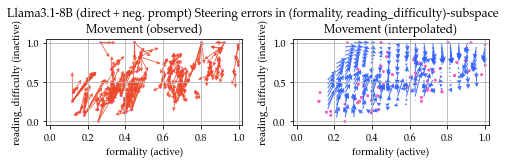

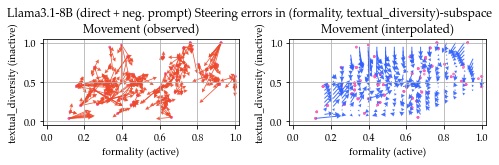

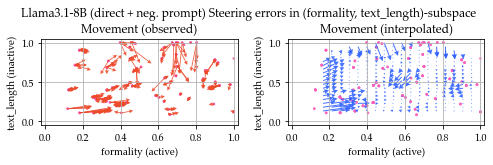

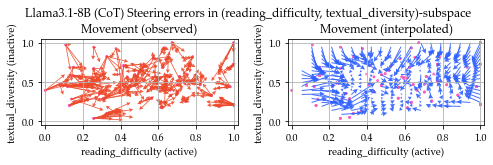

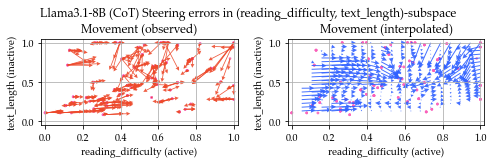

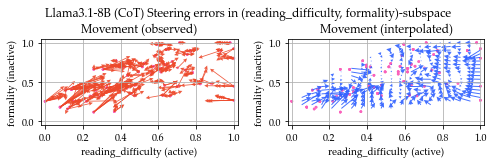

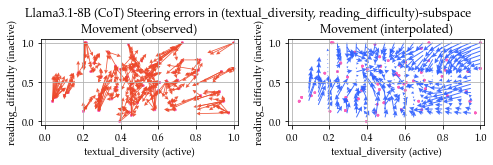

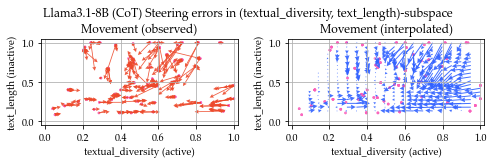

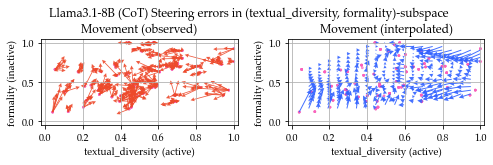

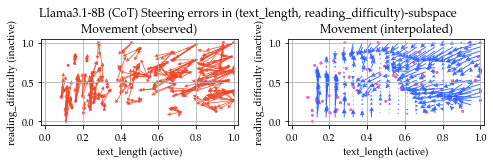

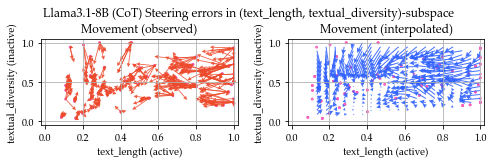

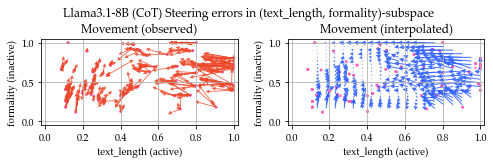

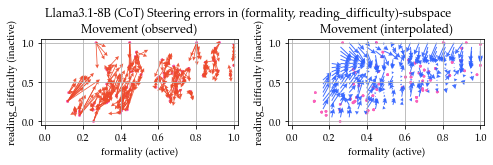

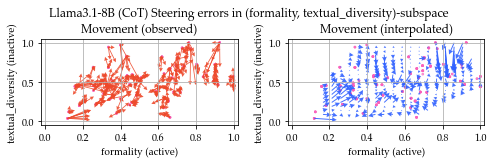

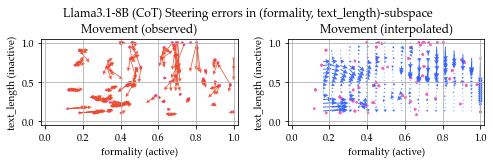

In [54]:
get_pairwise_flows(llama_results[0], "Llama3.1-8B (underspec. prompt)", exp_name="underspec")
get_pairwise_flows(llama_results[1], "Llama3.1-8B (direct prompt)", exp_name="directprompt")
get_pairwise_flows(llama_results[2], "Llama3.1-8B (direct + neg. prompt)", exp_name="negprompt")
get_pairwise_flows(llama_results[6], "Llama3.1-8B (CoT)", exp_name="cotprompt")

In [119]:
llama_results["instruction"].head(n=20).tolist()

['Please rewrite the following, but make it easier to read, use much less diverse language, and slightly more informal. Respond with only the rewritten text and do not explain your response.',
 'Please rewrite the following, but make it use less diverse language, more formal, and easier to read. Respond with only the rewritten text and do not explain your response.',
 'Please rewrite the following, but make it slightly harder to read, use less diverse language, and much more informal. Respond with only the rewritten text and do not explain your response.',
 'Please rewrite the following, but make it use much less diverse language, more formal, and easier to read. Respond with only the rewritten text and do not explain your response.',
 'Please rewrite the following, but make it slightly easier to read, use less diverse language, and much shorter. Respond with only the rewritten text and do not explain your response.',
 'Please rewrite the following, but make it use slightly more divers

# Scratch

In [73]:
ortho_unnorm = get_orthogonality(llama_results, normalize=False)
miscal_unnorm = get_miscalibration(llama_results, normalize=False)
error = get_dist_to_goal(llama_results)

error

array([0.69357813, 0.52157058, 1.09247875, ..., 1.01950701, 0.56626523,
       0.74339149])

In [74]:
(np.sqrt(ortho_unnorm ** 2 + miscal_unnorm ** 2) - error).describe()

count    2.048000e+03
mean    -3.616249e-09
std      3.810676e-09
min     -2.607063e-08
25%     -5.516919e-09
50%     -2.310705e-09
75%     -6.026141e-10
max      5.551115e-17
dtype: float64

In [91]:
get_grounded_subset(llama_results, flip=True)

2047 rewrites passed groudnedness check


original_index                                               text  \
2038            3275  God help\nthe noble Claudio! If he have caught...   

                                  source  reading_difficulty  \
2038  Dataset: kmfoda/booksum/validation                 2.4   

      textual_diversity  text_length  formality  source_reading_difficulty  \
2038           77.90736        235.0  47.740113                        0.0   

      source_textual_diversity  source_text_length  ...  \
2038                  0.395022            0.109713  ...   

                                              version_a  \
2038  God help\nthe noble Claudio! If he have caught...   

                                              version_b  source_text_is_a  \
2038  Alas, may Providence intervene on behalf of th...              True   

                                                 prompt  \
2038  You are an impartial judge comparing two texts...   

                                       raw_judge_output  \
2038  {\n    "answer": No,\n    "rationale": "The tw...   

                                     clean_judge_output  answer  \
2038  {\n    "answer": No,\n    "rationale": "The tw...      No   

                                              rationale  rationale_approved  \
2038  The two texts are not variations of the same t...                True   

      spot_check  
2038        True  

[1 rows x 47 columns]

In [57]:
preview_samples(llama_results, topk=-5)

`topk` is not None (-5) -- ignoring n.


text  \
233                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      His poppy-colored cheeks were distended with his first big bite of\nbread and bacon, but he managed to smile encouragingly. "If tha' was a missel thrush an' showed me where thy nest was, does\ntha' think I'd tell any one? Not me," he said. "Tha' art as safe as a\nmissel thrush." And she was quite sure she was.   
1346                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        this was a few days after christmas where my mom, when my mom made mac and cheese, which was a lot that she made. i didn't have any because i don't really like it. than i told her that i haven't have really good mac and cheese. than we started to playfully argue that why i didn't taste hers. i told her because of school and i didn't want to sleep late, it was about 12. we had to go home, and i had to wake up at four. so i didn't take any,....yeah i just fucked up.   
248                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [78]:
llama_results[llama_results["rationale_approved"] & (llama_results["answer"] == "Yes")]

original_index                                               text  \
0               2165  David Cameron, William Hague and Michael Gove ...   
1               2165  David Cameron, William Hague and Michael Gove ...   
2               2165  David Cameron, William Hague and Michael Gove ...   
3               2165  David Cameron, William Hague and Michael Gove ...   
4               2165  David Cameron, William Hague and Michael Gove ...   
...              ...                                                ...   
2043            3275  God help\nthe noble Claudio! If he have caught...   
2044            3275  God help\nthe noble Claudio! If he have caught...   
2045            3275  God help\nthe noble Claudio! If he have caught...   
2046            3275  God help\nthe noble Claudio! If he have caught...   
2047            3275  God help\nthe noble Claudio! If he have caught...   

                                            source  reading_difficulty  \
0     Dataset: ccdv/cnn_dailymail/3.0.0/validation                10.7   
1     Dataset: ccdv/cnn_dailymail/3.0.0/validation                10.7   
2     Dataset: ccdv/cnn_dailymail/3.0.0/validation                10.7   
3     Dataset: ccdv/cnn_dailymail/3.0.0/validation                10.7   
4     Dataset: ccdv/cnn_dailymail/3.0.0/validation                10.7   
...                                            ...                 ...   
2043            Dataset: kmfoda/booksum/validation                 2.4   
2044            Dataset: kmfoda/booksum/validation                 2.4   
2045            Dataset: kmfoda/booksum/validation                 2.4   
2046            Dataset: kmfoda/booksum/validation                 2.4   
2047            Dataset: kmfoda/booksum/validation                 2.4   

      textual_diversity  text_length  formality  source_reading_difficulty  \
0            113.579724       1224.0  58.180987                   0.782178   
1            113.579724       1224.0  58.180987                   0.782178   
2            113.579724       1224.0  58.180987                   0.782178   
3            113.579724       1224.0  58.180987                   0.782178   
4            113.579724       1224.0  58.180987                   0.782178   
...                 ...          ...        ...                        ...   
2043          77.907360        235.0  47.740113                   0.000000   
2044          77.907360        235.0  47.740113                   0.000000   
2045          77.907360        235.0  47.740113                   0.000000   
2046          77.907360        235.0  47.740113                   0.000000   
2047          77.907360        235.0  47.740113                   0.000000   

      source_textual_diversity  source_text_length  ...  \
0                     0.821215            0.800839  ...   
1                     0.821215            0.800839  ...   
2                     0.821215            0.800839  ...   
3                     0.821215            0.800839  ...   
4                     0.821215            0.800839  ...   
...                        ...                 ...  ...   
2043                  0.395022            0.109713  ...   
2044                  0.395022            0.109713  ...   
2045                  0.395022            0.109713  ...   
2046                  0.395022            0.109713  ...   
2047                  0.395022            0.109713  ...   

                                              version_a  \
0     David Cameron, William Hague and Michael Gove ...   
1     David Cameron, William Hague, and Michael Gove...   
2     So the Tories got totally owned last night aft...   
3     David Cameron, William Hague, and Michael Gove...   
4     David Cameron, William Hague and Michael Gove ...   
...                                                 ...   
2043  God help\nthe noble Claudio! If he have caught...   
2044  May Providence intervene on behalf of the este...   
2045  It is to be hoped that the noble 

In [11]:
from taaled import ld

text1 = 'His poppy-colored cheeks were distended with his first big bite of\nbread and bacon, but he managed to smile encouragingly. "If tha\' was a missel thrush an\' showed me where thy nest was, does\ntha\' think I\'d tell any one? Not me," he said. "Tha\' art as safe as a\nmissel thrush." And she was quite sure she was.'
text2 = (
    "His poppy-hued countenance, a vibrant testament to the unbridled joy that coursed through his being, was momentarily distorted by the sheer magnitude of his inaugural "
    "bite of the crispy, golden-brown bread and the savory, smoky bacon that lay nestled within, yet he somehow managed to muster a smile of unbridled encouragement, a beaming "
    "countenance that seemed to radiate an aura of unwavering optimism, as if to reassure her that all was indeed well. \"If, hypothetically speaking, thou wert a missel thrush, "
    "and thou didst deign to reveal to me the location of thy humble abode, I daresay I would not be so crass as to betray thy trust, nay, not I,\" he declared, his words dripping "
    "with an air of feigned nonchalance, as if to convey a sense of utter sincerity, \"for I am a man of my word, a paragon of virtue, and a stalwart defender of the innocent, and I "
    "would not dream of compromising thy safety, no, not for all the world.\" And she was quite, quite certain that she was safe, that she had found a true ally in this rugged, yet "
    "endearing individual, a man who seemed to possess a heart of gold, and a tongue that was as smooth as silk, and as persuasive as a summer breeze on a warm, languid afternoon."
)

ldvals = ld.lexdiv(text1)
ldvals.mtld

219.52000000000015

In [12]:
clean = lats.Normalize(text1, lats.ld_params_en)
ldvals = ld.lexdiv(clean.toks)
ldvals.mtld


78.49333333333335

In [13]:
lats.__file__

'/data2/ctrenton/miniconda3/envs/steerability/lib/python3.9/site-packages/pylats/lats.py'

In [6]:
from pylats import lats
from taaled import ld


In [3]:
!python -m spacy download es_core_news_sm
!python -m spacy download es_dep_news_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 39.4 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.8/407.8 MB 20.4 MB/s eta 0:00:0000:0100:01
  Using cached spacy_curated_transformers-0.2.2-py2.py3-none-any.whl.metadata (2.7 kB)
Using cached spacy_curated_transformers-0.2.2-py2.py3-none-any.whl (236 kB)
  Attempting uninstall: spacy-curated-transformers
    Found existing installation: spacy-curated-transformers 0.3.0
    Uninstalling spacy-curated-transformers-0.3.0:
      Successfully uninstalled spacy-curated-transformers-0.3.0
✔ Download and installation successful
You can now load the package via spacy.load('es_dep_news_trf')
